In [7]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../data/two_years_each/train_val_consistent'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

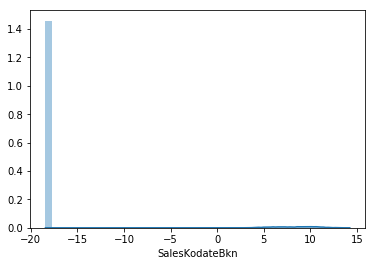

In [3]:
sns.distplot(np.log(df_train_Y['SalesKodateBkn'] + 0.00000001))
plt.plot()

In [4]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['SalesKodateBkn']:
    df_train_Y['SalesKodateBkn_log'] = df_train_Y['SalesKodateBkn'].apply(log)
    df_val_Y['SalesKodateBkn_log'] = df_val_Y['SalesKodateBkn'].apply(log)

### データ構造転換

In [5]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['SalesKodateBkn_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['SalesKodateBkn_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化

In [8]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=100, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['SalesRyutsu'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
optimize()

Training with params:                                                                                                  
{'alpha': 0.1352253794121665, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.01025028736314532, 'lambda': 0.001170731383737293, 'learning_rate': 0.125, 'max_depth': 6, 'min_child_weight': 0.2561507011801073, 'n_estimators': 266.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:16.3772	eval-rmse:16.4248                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:14.4945	eval-rmse:14.5672                                                                               

[2]	train-rmse:12.8653	eval-rmse:12.9565                                                             

loss: 113785881.22272056                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0004243010004743772, 'colsample_bytree': 0.9, 'gamma': 3.8436709091323345e-08, 'lambda': 0.6746173353200029, 'learning_rate': 0.17500000000000002, 'max_depth': 7, 'min_child_weight': 0.3943497748313235, 'n_estimators': 551.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:15.5035	eval-rmse:15.582                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.0246	eval-rmse:13.1527                                                           

[9]	train-rmse:4.28359	eval-rmse:5.25492                                                                               

[10]	train-rmse:4.08144	eval-rmse:5.11923                                                                              

[11]	train-rmse:3.93037	eval-rmse:5.02776                                                                              

[12]	train-rmse:3.82285	eval-rmse:4.98924                                                                              

[13]	train-rmse:3.74061	eval-rmse:4.94971                                                                              

[14]	train-rmse:3.68248	eval-rmse:4.91976                                                                              

[15]	train-rmse:3.64253	eval-rmse:4.90938                                                                              

[16]	train-rmse:3.6062	eval-rmse:4.89915                                                                               

[17]	train-rmse:3.57376	eval-rms

[27]	train-rmse:3.42309	eval-rmse:4.91923                                                                              

[28]	train-rmse:3.39632	eval-rmse:4.90969                                                                              

[29]	train-rmse:3.38286	eval-rmse:4.91721                                                                              

[30]	train-rmse:3.36431	eval-rmse:4.91014                                                                              

[31]	train-rmse:3.35728	eval-rmse:4.91527                                                                              

[32]	train-rmse:3.34256	eval-rmse:4.91597                                                                              

[33]	train-rmse:3.33029	eval-rmse:4.91861                                                                              

[34]	train-rmse:3.318	eval-rmse:4.9224                                                                                 

[35]	train-rmse:3.31046	eval-rms

[43]	train-rmse:4.41137	eval-rmse:4.78663                                                                              

[44]	train-rmse:4.40986	eval-rmse:4.78626                                                                              

[45]	train-rmse:4.40785	eval-rmse:4.78857                                                                              

[46]	train-rmse:4.40553	eval-rmse:4.78849                                                                              

Stopping. Best iteration:                                                                                              
[26]	train-rmse:4.45249	eval-rmse:4.77879


loss: 113768411.31336138                                                                                               
Training with params:                                                                                                  
{'alpha': 3.420001068822469e-07, 'colsample_bytree': 0.6000000000000001, 'gamma': 3.46161642741953e-05, 'lambda'

[55]	train-rmse:3.57309	eval-rmse:4.77524                                                                              

[56]	train-rmse:3.56989	eval-rmse:4.77628                                                                              

[57]	train-rmse:3.56374	eval-rmse:4.77614                                                                              

[58]	train-rmse:3.55935	eval-rmse:4.77437                                                                              

[59]	train-rmse:3.55244	eval-rmse:4.77175                                                                              

[60]	train-rmse:3.5487	eval-rmse:4.7731                                                                                

[61]	train-rmse:3.5439	eval-rmse:4.774                                                                                 

[62]	train-rmse:3.53943	eval-rmse:4.77418                                                                              

[63]	train-rmse:3.53031	eval-rms


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.36387	eval-rmse:7.68796                                                                               

[2]	train-rmse:5.44051	eval-rmse:5.96582                                                                               

[3]	train-rmse:4.59384	eval-rmse:5.26368                                                                               

[4]	train-rmse:4.22265	eval-rmse:5.01909                                                                               

[5]	train-rmse:4.05518	eval-rmse:4.95263                                                                               

[6]	train-rmse:3.96638	eval-rmse:4.94288                                                                               

[7]	train-rmse:3.91304	eval-rmse:4.94438                                                                               

[8]	train-rmse:3.87238	eval-rms

[29]	train-rmse:4.39405	eval-rmse:4.8501                                                                               

[30]	train-rmse:4.39111	eval-rmse:4.85119                                                                              

[31]	train-rmse:4.38448	eval-rmse:4.86031                                                                              

[32]	train-rmse:4.37889	eval-rmse:4.86492                                                                              

[33]	train-rmse:4.37602	eval-rmse:4.86606                                                                              

[34]	train-rmse:4.37162	eval-rmse:4.86657                                                                              

[35]	train-rmse:4.3684	eval-rmse:4.85895                                                                               

[36]	train-rmse:4.3629	eval-rmse:4.85389                                                                               

[37]	train-rmse:4.35715	eval-rms

[7]	train-rmse:5.80767	eval-rmse:6.16568                                                                               

[8]	train-rmse:5.36075	eval-rmse:5.76229                                                                               

[9]	train-rmse:5.02634	eval-rmse:5.47352                                                                               

[10]	train-rmse:4.77803	eval-rmse:5.26665                                                                              

[11]	train-rmse:4.59665	eval-rmse:5.11651                                                                              

[12]	train-rmse:4.4641	eval-rmse:5.01934                                                                               

[13]	train-rmse:4.36469	eval-rmse:4.94321                                                                              

[14]	train-rmse:4.29417	eval-rmse:4.89058                                                                              

[15]	train-rmse:4.23856	eval-rms

[17]	train-rmse:4.26619	eval-rmse:4.77801                                                                              

[18]	train-rmse:4.26154	eval-rmse:4.77798                                                                              

[19]	train-rmse:4.25575	eval-rmse:4.77466                                                                              

[20]	train-rmse:4.24287	eval-rmse:4.77954                                                                              

[21]	train-rmse:4.23463	eval-rmse:4.78815                                                                              

[22]	train-rmse:4.22688	eval-rmse:4.79366                                                                              

[23]	train-rmse:4.22037	eval-rmse:4.79487                                                                              

[24]	train-rmse:4.20835	eval-rmse:4.79408                                                                              

[25]	train-rmse:4.19481	eval-rms

[43]	train-rmse:3.58736	eval-rmse:4.81175                                                                              

[44]	train-rmse:3.57058	eval-rmse:4.80715                                                                              

[45]	train-rmse:3.55674	eval-rmse:4.80309                                                                              

[46]	train-rmse:3.54061	eval-rmse:4.80153                                                                              

[47]	train-rmse:3.5269	eval-rmse:4.80099                                                                               

[48]	train-rmse:3.51709	eval-rmse:4.79794                                                                              

[49]	train-rmse:3.50566	eval-rmse:4.79329                                                                              

[50]	train-rmse:3.49687	eval-rmse:4.79297                                                                              

[51]	train-rmse:3.48581	eval-rms

[26]	train-rmse:4.44902	eval-rmse:4.78487                                                                              

[27]	train-rmse:4.44517	eval-rmse:4.78719                                                                              

[28]	train-rmse:4.44141	eval-rmse:4.78386                                                                              

[29]	train-rmse:4.43843	eval-rmse:4.78583                                                                              

[30]	train-rmse:4.43566	eval-rmse:4.78675                                                                              

[31]	train-rmse:4.43305	eval-rmse:4.7858                                                                               

[32]	train-rmse:4.43204	eval-rmse:4.78547                                                                              

[33]	train-rmse:4.42988	eval-rmse:4.78391                                                                              

[34]	train-rmse:4.42801	eval-rms

{'alpha': 1.6505665096473651e-06, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.0005602792725895928, 'lambda': 1.532044273199916, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'min_child_weight': 1.0898251442973639, 'n_estimators': 827.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:17.2274	eval-rmse:17.2819                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:16.0098	eval-rmse:16.0982                                                                               

[2]	train-rmse:14.8876	eval-rmse:15.0166                                                                               

[3]	train-rmse:13.8574	eval-rmse:14.0189                                           

[63]	train-rmse:2.98909	eval-rmse:4.78201                                                                              

[64]	train-rmse:2.98252	eval-rmse:4.78197                                                                              

[65]	train-rmse:2.97035	eval-rmse:4.78081                                                                              

[66]	train-rmse:2.96769	eval-rmse:4.78084                                                                              

[67]	train-rmse:2.96124	eval-rmse:4.77953                                                                              

[68]	train-rmse:2.95758	eval-rmse:4.77852                                                                              

[69]	train-rmse:2.95615	eval-rmse:4.77803                                                                              

[70]	train-rmse:2.94944	eval-rmse:4.77515                                                                              

[71]	train-rmse:2.94461	eval-rms

{'alpha': 0.00014837625165502072, 'colsample_bytree': 0.8, 'gamma': 0.062093483633754686, 'lambda': 1.5020844563700313, 'learning_rate': 0.025, 'max_depth': 8, 'min_child_weight': 0.7775785527381989, 'n_estimators': 581.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:18.1075	eval-rmse:18.1385                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:17.6797	eval-rmse:17.7183                                                                               

[2]	train-rmse:17.2632	eval-rmse:17.3095                                                                               

[3]	train-rmse:16.858	eval-rmse:16.9131                                                                                

[4]	tr

[63]	train-rmse:5.25597	eval-rmse:5.95744                                                                              

[64]	train-rmse:5.19091	eval-rmse:5.90443                                                                              

[65]	train-rmse:5.12749	eval-rmse:5.85201                                                                              

[66]	train-rmse:5.06702	eval-rmse:5.80222                                                                              

[67]	train-rmse:5.00821	eval-rmse:5.75523                                                                              

[68]	train-rmse:4.95135	eval-rmse:5.71061                                                                              

[69]	train-rmse:4.89659	eval-rmse:5.66699                                                                              

[70]	train-rmse:4.84293	eval-rmse:5.62502                                                                              

[71]	train-rmse:4.79155	eval-rms

[24]	train-rmse:4.52336	eval-rmse:4.96078                                                                              

[25]	train-rmse:4.47961	eval-rmse:4.92028                                                                              

[26]	train-rmse:4.44237	eval-rmse:4.89105                                                                              

[27]	train-rmse:4.41137	eval-rmse:4.86763                                                                              

[28]	train-rmse:4.38575	eval-rmse:4.8494                                                                               

[29]	train-rmse:4.36344	eval-rmse:4.83235                                                                              

[30]	train-rmse:4.3434	eval-rmse:4.81742                                                                               

[31]	train-rmse:4.32811	eval-rmse:4.80808                                                                              

[32]	train-rmse:4.31259	eval-rms

[20]	train-rmse:3.29286	eval-rmse:5.06233                                                                              

[21]	train-rmse:3.27923	eval-rmse:5.06044                                                                              

[22]	train-rmse:3.24951	eval-rmse:5.06107                                                                              

[23]	train-rmse:3.23469	eval-rmse:5.06516                                                                              

[24]	train-rmse:3.21521	eval-rmse:5.07484                                                                              

[25]	train-rmse:3.20194	eval-rmse:5.07127                                                                              

[26]	train-rmse:3.18738	eval-rmse:5.07634                                                                              

[27]	train-rmse:3.17819	eval-rmse:5.07432                                                                              

[28]	train-rmse:3.16429	eval-rms

[47]	train-rmse:4.40565	eval-rmse:4.78947                                                                              

[48]	train-rmse:4.40064	eval-rmse:4.78756                                                                              

[49]	train-rmse:4.3948	eval-rmse:4.78488                                                                               

[50]	train-rmse:4.39121	eval-rmse:4.78348                                                                              

[51]	train-rmse:4.38718	eval-rmse:4.77793                                                                              

[52]	train-rmse:4.38276	eval-rmse:4.77539                                                                              

[53]	train-rmse:4.37862	eval-rmse:4.77434                                                                              

[54]	train-rmse:4.3751	eval-rmse:4.77614                                                                               

[55]	train-rmse:4.37205	eval-rms

[14]	train-rmse:9.40824	eval-rmse:9.63955                                                                              

[15]	train-rmse:9.03599	eval-rmse:9.28171                                                                              

[16]	train-rmse:8.68624	eval-rmse:8.9476                                                                               

[17]	train-rmse:8.35499	eval-rmse:8.63276                                                                              

[18]	train-rmse:8.04384	eval-rmse:8.33541                                                                              

[19]	train-rmse:7.75217	eval-rmse:8.05958                                                                              

[20]	train-rmse:7.47906	eval-rmse:7.8012                                                                               

[21]	train-rmse:7.22291	eval-rmse:7.56017                                                                              

[22]	train-rmse:6.98247	eval-rms

[81]	train-rmse:3.84905	eval-rmse:4.7789                                                                               

[82]	train-rmse:3.8435	eval-rmse:4.77978                                                                               

[83]	train-rmse:3.84019	eval-rmse:4.7782                                                                               

[84]	train-rmse:3.83498	eval-rmse:4.77751                                                                              

[85]	train-rmse:3.83088	eval-rmse:4.77554                                                                              

[86]	train-rmse:3.82714	eval-rmse:4.77586                                                                              

[87]	train-rmse:3.8241	eval-rmse:4.77608                                                                               

[88]	train-rmse:3.82117	eval-rmse:4.77604                                                                              

[89]	train-rmse:3.81839	eval-rms

[42]	train-rmse:3.69213	eval-rmse:4.84093                                                                              

[43]	train-rmse:3.6859	eval-rmse:4.84232                                                                               

[44]	train-rmse:3.67767	eval-rmse:4.83895                                                                              

[45]	train-rmse:3.66681	eval-rmse:4.8436                                                                               

[46]	train-rmse:3.6614	eval-rmse:4.84577                                                                               

[47]	train-rmse:3.65112	eval-rmse:4.84783                                                                              

[48]	train-rmse:3.64346	eval-rmse:4.85266                                                                              

[49]	train-rmse:3.63349	eval-rmse:4.85148                                                                              

[50]	train-rmse:3.62247	eval-rms

[40]	train-rmse:7.56708	eval-rmse:7.99664                                                                              

[41]	train-rmse:7.42844	eval-rmse:7.87079                                                                              

[42]	train-rmse:7.29373	eval-rmse:7.74941                                                                              

[43]	train-rmse:7.16375	eval-rmse:7.63184                                                                              

[44]	train-rmse:7.03689	eval-rmse:7.51877                                                                              

[45]	train-rmse:6.91509	eval-rmse:7.40938                                                                              

[46]	train-rmse:6.79558	eval-rmse:7.30177                                                                              

[47]	train-rmse:6.68046	eval-rmse:7.20002                                                                              

[48]	train-rmse:6.56865	eval-rms

[1]	train-rmse:13.7866	eval-rmse:13.8491                                                                               

[2]	train-rmse:11.969	eval-rmse:12.0515                                                                                

[3]	train-rmse:10.4603	eval-rmse:10.5721                                                                               

[4]	train-rmse:9.21457	eval-rmse:9.3586                                                                                

[5]	train-rmse:8.19063	eval-rmse:8.35689                                                                               

[6]	train-rmse:7.35905	eval-rmse:7.5431                                                                                

[7]	train-rmse:6.691	eval-rmse:6.90656                                                                                 

[8]	train-rmse:6.15916	eval-rmse:6.39128                                                                               

[9]	train-rmse:5.74392	eval-rmse

[12]	train-rmse:3.82902	eval-rmse:4.93334                                                                              

[13]	train-rmse:3.79602	eval-rmse:4.9278                                                                               

[14]	train-rmse:3.76002	eval-rmse:4.92896                                                                              

[15]	train-rmse:3.74411	eval-rmse:4.93052                                                                              

[16]	train-rmse:3.71498	eval-rmse:4.94729                                                                              

[17]	train-rmse:3.69104	eval-rmse:4.95516                                                                              

[18]	train-rmse:3.67535	eval-rmse:4.95633                                                                              

[19]	train-rmse:3.65253	eval-rmse:4.95458                                                                              

[20]	train-rmse:3.62758	eval-rms

[37]	train-rmse:3.70667	eval-rmse:4.87172                                                                              

[38]	train-rmse:3.67729	eval-rmse:4.85592                                                                              

[39]	train-rmse:3.65087	eval-rmse:4.84552                                                                              

[40]	train-rmse:3.62582	eval-rmse:4.83485                                                                              

[41]	train-rmse:3.60149	eval-rmse:4.82674                                                                              

[42]	train-rmse:3.58233	eval-rmse:4.82377                                                                              

[43]	train-rmse:3.56231	eval-rmse:4.81444                                                                              

[44]	train-rmse:3.54562	eval-rmse:4.80887                                                                              

[45]	train-rmse:3.53151	eval-rms

[11]	train-rmse:5.33682	eval-rmse:6.03994                                                                              

[12]	train-rmse:5.01539	eval-rmse:5.77591                                                                              

[13]	train-rmse:4.74377	eval-rmse:5.56264                                                                              

[14]	train-rmse:4.51957	eval-rmse:5.40162                                                                              

[15]	train-rmse:4.33805	eval-rmse:5.26808                                                                              

[16]	train-rmse:4.19163	eval-rmse:5.16475                                                                              

[17]	train-rmse:4.0652	eval-rmse:5.08243                                                                               

[18]	train-rmse:3.96526	eval-rmse:5.02056                                                                              

[19]	train-rmse:3.87735	eval-rms

[7]	train-rmse:5.68145	eval-rmse:6.17759                                                                               

[8]	train-rmse:5.21287	eval-rmse:5.77605                                                                               

[9]	train-rmse:4.85678	eval-rmse:5.47599                                                                               

[10]	train-rmse:4.594	eval-rmse:5.26885                                                                                

[11]	train-rmse:4.39623	eval-rmse:5.13044                                                                              

[12]	train-rmse:4.24851	eval-rmse:5.02397                                                                              

[13]	train-rmse:4.1374	eval-rmse:4.94275                                                                               

[14]	train-rmse:4.05766	eval-rmse:4.88653                                                                              

[15]	train-rmse:3.9947	eval-rmse

[23]	train-rmse:4.47588	eval-rmse:4.84969                                                                              

[24]	train-rmse:4.45666	eval-rmse:4.83332                                                                              

[25]	train-rmse:4.44154	eval-rmse:4.82008                                                                              

[26]	train-rmse:4.42845	eval-rmse:4.81082                                                                              

[27]	train-rmse:4.41703	eval-rmse:4.80146                                                                              

[28]	train-rmse:4.40609	eval-rmse:4.79493                                                                              

[29]	train-rmse:4.39846	eval-rmse:4.79493                                                                              

[30]	train-rmse:4.39212	eval-rmse:4.78998                                                                              

[31]	train-rmse:4.38496	eval-rms

[10]	train-rmse:14.3423	eval-rmse:14.4278                                                                              

[11]	train-rmse:14.0174	eval-rmse:14.1095                                                                              

[12]	train-rmse:13.7019	eval-rmse:13.7998                                                                              

[13]	train-rmse:13.3976	eval-rmse:13.4999                                                                              

[14]	train-rmse:13.0991	eval-rmse:13.2061                                                                              

[15]	train-rmse:12.8087	eval-rmse:12.9229                                                                              

[16]	train-rmse:12.5279	eval-rmse:12.6452                                                                              

[17]	train-rmse:12.2536	eval-rmse:12.379                                                                               

[18]	train-rmse:11.9895	eval-rms

[77]	train-rmse:4.907	eval-rmse:5.40697                                                                                

[78]	train-rmse:4.87253	eval-rmse:5.37816                                                                              

[79]	train-rmse:4.83907	eval-rmse:5.35026                                                                              

[80]	train-rmse:4.80687	eval-rmse:5.32528                                                                              

[81]	train-rmse:4.77638	eval-rmse:5.29984                                                                              

[82]	train-rmse:4.74594	eval-rmse:5.27629                                                                              

[83]	train-rmse:4.71813	eval-rmse:5.25269                                                                              

[84]	train-rmse:4.69048	eval-rmse:5.22985                                                                              

[85]	train-rmse:4.66428	eval-rms

[38]	train-rmse:3.22969	eval-rmse:4.82859                                                                              

[39]	train-rmse:3.21098	eval-rmse:4.83072                                                                              

[40]	train-rmse:3.19709	eval-rmse:4.83225                                                                              

[41]	train-rmse:3.18011	eval-rmse:4.84131                                                                              

[42]	train-rmse:3.16987	eval-rmse:4.84138                                                                              

Stopping. Best iteration:                                                                                              
[22]	train-rmse:3.46347	eval-rmse:4.79484


loss: 126241726.59288272                                                                                               
Training with params:                                                                                          

[13]	train-rmse:5.86144	eval-rmse:6.33002                                                                              

[14]	train-rmse:5.56288	eval-rmse:6.07876                                                                              

[15]	train-rmse:5.30608	eval-rmse:5.86163                                                                              

[16]	train-rmse:5.08834	eval-rmse:5.68423                                                                              

[17]	train-rmse:4.89891	eval-rmse:5.54055                                                                              

[18]	train-rmse:4.73827	eval-rmse:5.41056                                                                              

[19]	train-rmse:4.60111	eval-rmse:5.30715                                                                              

[20]	train-rmse:4.48638	eval-rmse:5.21892                                                                              

[21]	train-rmse:4.38678	eval-rms

[9]	train-rmse:5.27302	eval-rmse:5.47375                                                                               

[10]	train-rmse:5.04587	eval-rmse:5.25926                                                                              

[11]	train-rmse:4.88373	eval-rmse:5.11109                                                                              

[12]	train-rmse:4.76814	eval-rmse:5.00598                                                                              

[13]	train-rmse:4.68572	eval-rmse:4.93495                                                                              

[14]	train-rmse:4.62812	eval-rmse:4.87792                                                                              

[15]	train-rmse:4.5851	eval-rmse:4.84197                                                                               

[16]	train-rmse:4.55345	eval-rmse:4.81722                                                                              

[17]	train-rmse:4.53085	eval-rms

[8]	train-rmse:4.49094	eval-rmse:5.16456                                                                               

[9]	train-rmse:4.30632	eval-rmse:5.03321                                                                               

[10]	train-rmse:4.17872	eval-rmse:4.94409                                                                              

[11]	train-rmse:4.09349	eval-rmse:4.88968                                                                              

[12]	train-rmse:4.03492	eval-rmse:4.8603                                                                               

[13]	train-rmse:3.99073	eval-rmse:4.84385                                                                              

[14]	train-rmse:3.96104	eval-rmse:4.83106                                                                              

[15]	train-rmse:3.92971	eval-rmse:4.82792                                                                              

[16]	train-rmse:3.90807	eval-rms

[28]	train-rmse:4.11215	eval-rmse:4.84421                                                                              

[29]	train-rmse:4.09867	eval-rmse:4.85258                                                                              

[30]	train-rmse:4.09232	eval-rmse:4.85187                                                                              

[31]	train-rmse:4.08649	eval-rmse:4.84929                                                                              

[32]	train-rmse:4.07561	eval-rmse:4.84477                                                                              

[33]	train-rmse:4.07213	eval-rmse:4.84562                                                                              

[34]	train-rmse:4.06652	eval-rmse:4.84443                                                                              

[35]	train-rmse:4.05391	eval-rmse:4.84385                                                                              

[36]	train-rmse:4.04162	eval-rms

[48]	train-rmse:3.99946	eval-rmse:4.98168                                                                              

[49]	train-rmse:3.96606	eval-rmse:4.9589                                                                               

[50]	train-rmse:3.93587	eval-rmse:4.93905                                                                              

[51]	train-rmse:3.90556	eval-rmse:4.92225                                                                              

[52]	train-rmse:3.87708	eval-rmse:4.90645                                                                              

[53]	train-rmse:3.85399	eval-rmse:4.89035                                                                              

[54]	train-rmse:3.83093	eval-rmse:4.87595                                                                              

[55]	train-rmse:3.80989	eval-rmse:4.86558                                                                              

[56]	train-rmse:3.78788	eval-rms

[9]	train-rmse:5.58264	eval-rmse:5.97593                                                                               

[10]	train-rmse:5.24357	eval-rmse:5.66944                                                                              

[11]	train-rmse:4.97742	eval-rmse:5.43828                                                                              

[12]	train-rmse:4.77423	eval-rmse:5.26236                                                                              

[13]	train-rmse:4.61659	eval-rmse:5.13086                                                                              

[14]	train-rmse:4.49428	eval-rmse:5.04121                                                                              

[15]	train-rmse:4.40236	eval-rmse:4.96875                                                                              

[16]	train-rmse:4.33392	eval-rmse:4.92851                                                                              

[17]	train-rmse:4.27467	eval-rms

[4]	train-rmse:11.5994	eval-rmse:11.6774                                                                               

[5]	train-rmse:10.6363	eval-rmse:10.7226                                                                               

[6]	train-rmse:9.78445	eval-rmse:9.88545                                                                               

[7]	train-rmse:9.03577	eval-rmse:9.14809                                                                               

[8]	train-rmse:8.37821	eval-rmse:8.50096                                                                               

[9]	train-rmse:7.80296	eval-rmse:7.93812                                                                               

[10]	train-rmse:7.30138	eval-rmse:7.44677                                                                              

[11]	train-rmse:6.86607	eval-rmse:7.02373                                                                              

[12]	train-rmse:6.4927	eval-rmse

[71]	train-rmse:4.41339	eval-rmse:4.74822                                                                              

[72]	train-rmse:4.4117	eval-rmse:4.74732                                                                               

[73]	train-rmse:4.40995	eval-rmse:4.74505                                                                              

[74]	train-rmse:4.40883	eval-rmse:4.74563                                                                              

[75]	train-rmse:4.4079	eval-rmse:4.74566                                                                               

[76]	train-rmse:4.40675	eval-rmse:4.74505                                                                              

[77]	train-rmse:4.40538	eval-rmse:4.74526                                                                              

[78]	train-rmse:4.40481	eval-rmse:4.7453                                                                               

[79]	train-rmse:4.40313	eval-rms

[4]	train-rmse:4.53163	eval-rmse:4.87939                                                                               

[5]	train-rmse:4.488	eval-rmse:4.84495                                                                                 

[6]	train-rmse:4.46846	eval-rmse:4.8429                                                                                

[7]	train-rmse:4.45375	eval-rmse:4.8513                                                                                

[8]	train-rmse:4.4397	eval-rmse:4.84846                                                                                

[9]	train-rmse:4.43341	eval-rmse:4.84779                                                                               

[10]	train-rmse:4.42298	eval-rmse:4.92516                                                                              

[11]	train-rmse:4.41386	eval-rmse:4.93038                                                                              

[12]	train-rmse:4.41218	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.305	eval-rmse:12.4704                                                                                

[2]	train-rmse:10.1482	eval-rmse:10.3974                                                                               

[3]	train-rmse:8.46939	eval-rmse:8.81421                                                                               

[4]	train-rmse:7.17911	eval-rmse:7.63101                                                                               

[5]	train-rmse:6.19918	eval-rmse:6.75025                                                                               

[6]	train-rmse:5.47037	eval-rmse:6.11298                                                                               

[7]	train-rmse:4.92721	eval-rms

[17]	train-rmse:8.39669	eval-rmse:8.63119                                                                              

[18]	train-rmse:8.09004	eval-rmse:8.33776                                                                              

[19]	train-rmse:7.80197	eval-rmse:8.06043                                                                              

[20]	train-rmse:7.53222	eval-rmse:7.80523                                                                              

[21]	train-rmse:7.27972	eval-rmse:7.56754                                                                              

[22]	train-rmse:7.04329	eval-rmse:7.34446                                                                              

[23]	train-rmse:6.82123	eval-rmse:7.13713                                                                              

[24]	train-rmse:6.61576	eval-rmse:6.94385                                                                              

[25]	train-rmse:6.4232	eval-rmse

[84]	train-rmse:4.01281	eval-rmse:4.79556                                                                              

[85]	train-rmse:4.00896	eval-rmse:4.79481                                                                              

[86]	train-rmse:4.00518	eval-rmse:4.79561                                                                              

[87]	train-rmse:4.00264	eval-rmse:4.79564                                                                              

[88]	train-rmse:4.00054	eval-rmse:4.79581                                                                              

[89]	train-rmse:3.99573	eval-rmse:4.79522                                                                              

[90]	train-rmse:3.99278	eval-rmse:4.79577                                                                              

[91]	train-rmse:3.99012	eval-rmse:4.79464                                                                              

[92]	train-rmse:3.98593	eval-rms

{'alpha': 1.6782331925221002e-05, 'colsample_bytree': 0.8, 'gamma': 1.056677810935739e-07, 'lambda': 0.23212411928633528, 'learning_rate': 0.375, 'max_depth': 9, 'min_child_weight': 0.6621357591524906, 'n_estimators': 790.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:12.0344	eval-rmse:12.2971                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.13317	eval-rmse:8.62613                                                                               

[2]	train-rmse:5.90234	eval-rmse:6.67562                                                                               

[3]	train-rmse:4.69535	eval-rmse:5.75543                                                                      

[27]	train-rmse:3.65888	eval-rmse:5.30133                                                                              

Stopping. Best iteration:                                                                                              
[7]	train-rmse:4.07458	eval-rmse:4.99899


loss: 2.640860538771296e+19                                                                                            
Training with params:                                                                                                  
{'alpha': 0.0009057025203551893, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.3332548557406403, 'lambda': 6.60836681367822e-05, 'learning_rate': 0.30000000000000004, 'max_depth': 8, 'min_child_weight': 1.5044036016639433, 'n_estimators': 646.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:13.336	eval-rmse:13.4833                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be 

[16]	train-rmse:4.35091	eval-rmse:4.8157                                                                               

[17]	train-rmse:4.3211	eval-rmse:4.80157                                                                               

[18]	train-rmse:4.29664	eval-rmse:4.78617                                                                              

[19]	train-rmse:4.27834	eval-rmse:4.77714                                                                              

[20]	train-rmse:4.26492	eval-rmse:4.77084                                                                              

[21]	train-rmse:4.25244	eval-rmse:4.76449                                                                              

[22]	train-rmse:4.24294	eval-rmse:4.76193                                                                              

[23]	train-rmse:4.23546	eval-rmse:4.76053                                                                              

[24]	train-rmse:4.22438	eval-rms

[30]	train-rmse:3.15283	eval-rmse:4.77284                                                                              

[31]	train-rmse:3.12813	eval-rmse:4.77098                                                                              

[32]	train-rmse:3.10944	eval-rmse:4.76895                                                                              

[33]	train-rmse:3.101	eval-rmse:4.76769                                                                                

[34]	train-rmse:3.08928	eval-rmse:4.76745                                                                              

[35]	train-rmse:3.07787	eval-rmse:4.76701                                                                              

[36]	train-rmse:3.06714	eval-rmse:4.76925                                                                              

[37]	train-rmse:3.05599	eval-rmse:4.7676                                                                               

[38]	train-rmse:3.04955	eval-rms

[30]	train-rmse:4.31079	eval-rmse:5.06112                                                                              

[31]	train-rmse:4.25513	eval-rmse:5.02167                                                                              

[32]	train-rmse:4.20814	eval-rmse:4.99021                                                                              

[33]	train-rmse:4.16647	eval-rmse:4.96728                                                                              

[34]	train-rmse:4.12695	eval-rmse:4.94088                                                                              

[35]	train-rmse:4.09509	eval-rmse:4.92184                                                                              

[36]	train-rmse:4.06244	eval-rmse:4.90495                                                                              

[37]	train-rmse:4.03296	eval-rmse:4.88921                                                                              

[38]	train-rmse:4.0044	eval-rmse

[8]	train-rmse:5.10804	eval-rmse:5.36703                                                                               

[9]	train-rmse:4.88454	eval-rmse:5.15263                                                                               

[10]	train-rmse:4.73116	eval-rmse:5.01403                                                                              

[11]	train-rmse:4.62509	eval-rmse:4.92174                                                                              

[12]	train-rmse:4.55486	eval-rmse:4.85545                                                                              

[13]	train-rmse:4.50651	eval-rmse:4.81418                                                                              

[14]	train-rmse:4.47185	eval-rmse:4.79578                                                                              

[15]	train-rmse:4.44933	eval-rmse:4.77466                                                                              

[16]	train-rmse:4.43012	eval-rms

[27]	train-rmse:4.25602	eval-rmse:4.88356                                                                              

[28]	train-rmse:4.22741	eval-rmse:4.86622                                                                              

[29]	train-rmse:4.20098	eval-rmse:4.8549                                                                               

[30]	train-rmse:4.17797	eval-rmse:4.84441                                                                              

[31]	train-rmse:4.16044	eval-rmse:4.83649                                                                              

[32]	train-rmse:4.14678	eval-rmse:4.82288                                                                              

[33]	train-rmse:4.1307	eval-rmse:4.81939                                                                               

[34]	train-rmse:4.11678	eval-rmse:4.81667                                                                              

[35]	train-rmse:4.10525	eval-rms

[6]	train-rmse:4.61309	eval-rmse:5.56472                                                                               

[7]	train-rmse:4.28415	eval-rmse:5.31538                                                                               

[8]	train-rmse:4.07681	eval-rmse:5.18306                                                                               

[9]	train-rmse:3.93334	eval-rmse:5.12265                                                                               

[10]	train-rmse:3.84181	eval-rmse:5.07825                                                                              

[11]	train-rmse:3.77342	eval-rmse:5.05244                                                                              

[12]	train-rmse:3.72699	eval-rmse:5.03826                                                                              

[13]	train-rmse:3.69275	eval-rmse:5.03722                                                                              

[14]	train-rmse:3.6596	eval-rmse

[28]	train-rmse:4.4591	eval-rmse:4.76245                                                                               

[29]	train-rmse:4.45571	eval-rmse:4.76264                                                                              

[30]	train-rmse:4.45324	eval-rmse:4.76042                                                                              

[31]	train-rmse:4.45017	eval-rmse:4.75948                                                                              

[32]	train-rmse:4.44774	eval-rmse:4.75879                                                                              

[33]	train-rmse:4.44539	eval-rmse:4.76033                                                                              

[34]	train-rmse:4.44365	eval-rmse:4.76135                                                                              

[35]	train-rmse:4.44144	eval-rmse:4.76175                                                                              

[36]	train-rmse:4.43894	eval-rms

[34]	train-rmse:5.04942	eval-rmse:5.65591                                                                              

[35]	train-rmse:4.95456	eval-rmse:5.57772                                                                              

[36]	train-rmse:4.8657	eval-rmse:5.50457                                                                               

[37]	train-rmse:4.78474	eval-rmse:5.44011                                                                              

[38]	train-rmse:4.70826	eval-rmse:5.38032                                                                              

[39]	train-rmse:4.6384	eval-rmse:5.32496                                                                               

[40]	train-rmse:4.5731	eval-rmse:5.27723                                                                               

[41]	train-rmse:4.51167	eval-rmse:5.23163                                                                              

[42]	train-rmse:4.45631	eval-rms

Training with params:                                                                                                  
{'alpha': 0.2564796156864963, 'colsample_bytree': 0.9, 'gamma': 0.025134618139287128, 'lambda': 0.01825385545384716, 'learning_rate': 0.17500000000000002, 'max_depth': 8, 'min_child_weight': 0.23391131912777818, 'n_estimators': 336.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:15.4934	eval-rmse:15.5807                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.0014	eval-rmse:13.1629                                                                               

[2]	train-rmse:10.9792	eval-rmse:11.2087                                                             

[13]	train-rmse:3.24566	eval-rmse:5.06003                                                                              

[14]	train-rmse:3.22436	eval-rmse:5.07454                                                                              

[15]	train-rmse:3.2113	eval-rmse:5.08747                                                                               

[16]	train-rmse:3.19897	eval-rmse:5.08945                                                                              

[17]	train-rmse:3.15771	eval-rmse:5.10617                                                                              

[18]	train-rmse:3.14875	eval-rmse:5.10958                                                                              

[19]	train-rmse:3.11803	eval-rmse:5.10709                                                                              

[20]	train-rmse:3.10716	eval-rmse:5.10544                                                                              

[21]	train-rmse:3.08272	eval-rms

[41]	train-rmse:7.66066	eval-rmse:7.85774                                                                              

[42]	train-rmse:7.53365	eval-rmse:7.73611                                                                              

[43]	train-rmse:7.41092	eval-rmse:7.61683                                                                              

[44]	train-rmse:7.29049	eval-rmse:7.50231                                                                              

[45]	train-rmse:7.17601	eval-rmse:7.39171                                                                              

[46]	train-rmse:7.0647	eval-rmse:7.28618                                                                               

[47]	train-rmse:6.95736	eval-rmse:7.18302                                                                              

[48]	train-rmse:6.85273	eval-rmse:7.08404                                                                              

[49]	train-rmse:6.75265	eval-rms

[2]	train-rmse:9.43869	eval-rmse:9.68324                                                                               

[3]	train-rmse:7.78329	eval-rmse:8.11383                                                                               

[4]	train-rmse:6.58123	eval-rmse:6.99354                                                                               

[5]	train-rmse:5.72085	eval-rmse:6.22173                                                                               

[6]	train-rmse:5.12078	eval-rmse:5.71323                                                                               

[7]	train-rmse:4.71218	eval-rmse:5.37258                                                                               

[8]	train-rmse:4.43426	eval-rmse:5.1613                                                                                

[9]	train-rmse:4.24549	eval-rmse:5.02936                                                                               

[10]	train-rmse:4.10813	eval-rms

[18]	train-rmse:3.92934	eval-rmse:5.01341                                                                              

[19]	train-rmse:3.84112	eval-rmse:4.96417                                                                              

[20]	train-rmse:3.77765	eval-rmse:4.92362                                                                              

[21]	train-rmse:3.71638	eval-rmse:4.89565                                                                              

[22]	train-rmse:3.66994	eval-rmse:4.87394                                                                              

[23]	train-rmse:3.62769	eval-rmse:4.85977                                                                              

[24]	train-rmse:3.58016	eval-rmse:4.84449                                                                              

[25]	train-rmse:3.54645	eval-rmse:4.83555                                                                              

[26]	train-rmse:3.5203	eval-rmse

[15]	train-rmse:6.88235	eval-rmse:7.0758                                                                               

[16]	train-rmse:6.59024	eval-rmse:6.79197                                                                              

[17]	train-rmse:6.32894	eval-rmse:6.54132                                                                              

[18]	train-rmse:6.09633	eval-rmse:6.32003                                                                              

[19]	train-rmse:5.88981	eval-rmse:6.12285                                                                              

[20]	train-rmse:5.70589	eval-rmse:5.9495                                                                               

[21]	train-rmse:5.54323	eval-rmse:5.79556                                                                              

[22]	train-rmse:5.39923	eval-rmse:5.65866                                                                              

[23]	train-rmse:5.2731	eval-rmse

{'alpha': 0.04809134237504912, 'colsample_bytree': 0.8500000000000001, 'gamma': 5.582898181432808e-07, 'lambda': 0.010383203376423348, 'learning_rate': 0.30000000000000004, 'max_depth': 6, 'min_child_weight': 1.287423846322167, 'n_estimators': 416.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:13.3829	eval-rmse:13.4797                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.89574	eval-rmse:10.0664                                                                               

[2]	train-rmse:7.6053	eval-rmse:7.86498                                                                                

[3]	train-rmse:6.16302	eval-rmse:6.5313                                             

[18]	train-rmse:3.84954	eval-rmse:4.902                                                                                

[19]	train-rmse:3.84171	eval-rmse:4.90094                                                                              

[20]	train-rmse:3.83668	eval-rmse:4.90392                                                                              

[21]	train-rmse:3.82432	eval-rmse:4.90946                                                                              

[22]	train-rmse:3.80509	eval-rmse:4.91462                                                                              

[23]	train-rmse:3.79417	eval-rmse:4.9154                                                                               

[24]	train-rmse:3.78949	eval-rmse:4.91134                                                                              

[25]	train-rmse:3.77964	eval-rmse:4.9148                                                                               

[26]	train-rmse:3.76992	eval-rms

[42]	train-rmse:2.90431	eval-rmse:4.82579                                                                              

[43]	train-rmse:2.89446	eval-rmse:4.82415                                                                              

[44]	train-rmse:2.8871	eval-rmse:4.8229                                                                                

[45]	train-rmse:2.87571	eval-rmse:4.82748                                                                              

[46]	train-rmse:2.86066	eval-rmse:4.83101                                                                              

[47]	train-rmse:2.85369	eval-rmse:4.83182                                                                              

[48]	train-rmse:2.83719	eval-rmse:4.83183                                                                              

Stopping. Best iteration:                                                                                              
[28]	train-rmse:3.06313	eval-rmse

[53]	train-rmse:2.95111	eval-rmse:4.83282                                                                              

[54]	train-rmse:2.93943	eval-rmse:4.83467                                                                              

[55]	train-rmse:2.93438	eval-rmse:4.83586                                                                              

[56]	train-rmse:2.9286	eval-rmse:4.83586                                                                               

[57]	train-rmse:2.91743	eval-rmse:4.83548                                                                              

[58]	train-rmse:2.91067	eval-rmse:4.83596                                                                              

[59]	train-rmse:2.89419	eval-rmse:4.83853                                                                              

[60]	train-rmse:2.88728	eval-rmse:4.83623                                                                              

[61]	train-rmse:2.88099	eval-rms

[27]	train-rmse:3.16614	eval-rmse:4.86314                                                                              

[28]	train-rmse:3.14888	eval-rmse:4.86444                                                                              

[29]	train-rmse:3.14247	eval-rmse:4.86437                                                                              

[30]	train-rmse:3.13277	eval-rmse:4.86274                                                                              

[31]	train-rmse:3.1204	eval-rmse:4.86292                                                                               

[32]	train-rmse:3.10417	eval-rmse:4.86616                                                                              

[33]	train-rmse:3.09628	eval-rmse:4.86599                                                                              

[34]	train-rmse:3.08421	eval-rmse:4.86478                                                                              

[35]	train-rmse:3.07516	eval-rms

[36]	train-rmse:3.29314	eval-rmse:4.80901                                                                              

[37]	train-rmse:3.28378	eval-rmse:4.81065                                                                              

[38]	train-rmse:3.27202	eval-rmse:4.80814                                                                              

[39]	train-rmse:3.26505	eval-rmse:4.80799                                                                              

[40]	train-rmse:3.25498	eval-rmse:4.80829                                                                              

[41]	train-rmse:3.25061	eval-rmse:4.8075                                                                               

[42]	train-rmse:3.23984	eval-rmse:4.807                                                                                

[43]	train-rmse:3.23186	eval-rmse:4.80676                                                                              

[44]	train-rmse:3.22391	eval-rms

[25]	train-rmse:3.06195	eval-rmse:4.81391                                                                              

[26]	train-rmse:3.04485	eval-rmse:4.82123                                                                              

[27]	train-rmse:3.03249	eval-rmse:4.81663                                                                              

[28]	train-rmse:3.02158	eval-rmse:4.81773                                                                              

[29]	train-rmse:3.01022	eval-rmse:4.81919                                                                              

[30]	train-rmse:2.99874	eval-rmse:4.8178                                                                               

[31]	train-rmse:2.98527	eval-rmse:4.81695                                                                              

[32]	train-rmse:2.97131	eval-rmse:4.81776                                                                              

[33]	train-rmse:2.96327	eval-rms

[43]	train-rmse:2.91068	eval-rmse:4.86382                                                                              

[44]	train-rmse:2.8921	eval-rmse:4.86908                                                                               

[45]	train-rmse:2.8819	eval-rmse:4.8698                                                                                

[46]	train-rmse:2.87149	eval-rmse:4.87311                                                                              

Stopping. Best iteration:                                                                                              
[26]	train-rmse:3.11586	eval-rmse:4.83537


loss: 114014492.6531945                                                                                                
Training with params:                                                                                                  
{'alpha': 0.017314675777310197, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.00040198772564216937, 'lambda

[1]	train-rmse:15.2274	eval-rmse:15.3231                                                                               

[2]	train-rmse:13.8268	eval-rmse:13.9536                                                                               

[3]	train-rmse:12.5735	eval-rmse:12.7363                                                                               

[4]	train-rmse:11.4592	eval-rmse:11.6617                                                                               

[5]	train-rmse:10.4635	eval-rmse:10.7142                                                                               

[6]	train-rmse:9.58015	eval-rmse:9.8718                                                                                

[7]	train-rmse:8.79464	eval-rmse:9.13466                                                                               

[8]	train-rmse:8.10026	eval-rmse:8.49477                                                                               

[9]	train-rmse:7.48732	eval-rmse

Stopping. Best iteration:                                                                                              
[47]	train-rmse:3.39012	eval-rmse:4.79506


loss: 113769443.92259553                                                                                               
Training with params:                                                                                                  
{'alpha': 7.94939338155047e-06, 'colsample_bytree': 0.8, 'gamma': 7.507708431669258e-05, 'lambda': 6.203451182047901e-05, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 0.1409623485617696, 'n_estimators': 964.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:17.6631	eval-rmse:17.7093                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.              

[60]	train-rmse:3.27384	eval-rmse:4.83181                                                                              

[61]	train-rmse:3.2566	eval-rmse:4.82674                                                                               

[62]	train-rmse:3.23845	eval-rmse:4.82146                                                                              

[63]	train-rmse:3.22217	eval-rmse:4.8188                                                                               

[64]	train-rmse:3.20927	eval-rmse:4.81439                                                                              

[65]	train-rmse:3.19538	eval-rmse:4.8088                                                                               

[66]	train-rmse:3.18063	eval-rmse:4.80405                                                                              

[67]	train-rmse:3.16535	eval-rmse:4.80312                                                                              

[68]	train-rmse:3.15226	eval-rms

[21]	train-rmse:3.72962	eval-rmse:4.84157                                                                              

[22]	train-rmse:3.72362	eval-rmse:4.84398                                                                              

[23]	train-rmse:3.70705	eval-rmse:4.84631                                                                              

[24]	train-rmse:3.69674	eval-rmse:4.84501                                                                              

[25]	train-rmse:3.69268	eval-rmse:4.84654                                                                              

[26]	train-rmse:3.68933	eval-rmse:4.84915                                                                              

[27]	train-rmse:3.66486	eval-rmse:4.8487                                                                               

[28]	train-rmse:3.64519	eval-rmse:4.85058                                                                              

[29]	train-rmse:3.62336	eval-rms

{'alpha': 0.054314552815290185, 'colsample_bytree': 0.7000000000000001, 'gamma': 4.003517654630058e-06, 'lambda': 6.521948922077751, 'learning_rate': 0.47500000000000003, 'max_depth': 4, 'min_child_weight': 0.8545449541616266, 'n_estimators': 591.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:10.5481	eval-rmse:10.619                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.78227	eval-rmse:6.97276                                                                               

[2]	train-rmse:5.25265	eval-rmse:5.51417                                                                               

[3]	train-rmse:4.72372	eval-rmse:5.02316                                                            

[27]	train-rmse:4.27269	eval-rmse:5.22978                                                                              

[28]	train-rmse:4.18394	eval-rmse:5.17081                                                                              

[29]	train-rmse:4.10679	eval-rmse:5.11751                                                                              

[30]	train-rmse:4.03625	eval-rmse:5.07213                                                                              

[31]	train-rmse:3.97472	eval-rmse:5.03472                                                                              

[32]	train-rmse:3.91871	eval-rmse:5.00255                                                                              

[33]	train-rmse:3.86814	eval-rmse:4.97004                                                                              

[34]	train-rmse:3.82091	eval-rmse:4.94825                                                                              

[35]	train-rmse:3.78211	eval-rms

[94]	train-rmse:3.22993	eval-rmse:4.80382                                                                              

[95]	train-rmse:3.22445	eval-rmse:4.80238                                                                              

[96]	train-rmse:3.21995	eval-rmse:4.80201                                                                              

Stopping. Best iteration:                                                                                              
[76]	train-rmse:3.33066	eval-rmse:4.79667


loss: 113767886.54425909                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00021964773574854307, 'colsample_bytree': 0.65, 'gamma': 2.8565756437341176e-07, 'lambda': 1.2091178020679574, 'learning_rate': 0.025, 'max_depth': 9, 'min_child_weight': 0.20769189675997957, 'n_estimators': 785.0, 'nthre

[57]	train-rmse:5.56681	eval-rmse:6.33703                                                                              

[58]	train-rmse:5.48391	eval-rmse:6.26893                                                                              

[59]	train-rmse:5.40353	eval-rmse:6.2048                                                                               

[60]	train-rmse:5.32709	eval-rmse:6.14076                                                                              

[61]	train-rmse:5.25138	eval-rmse:6.08022                                                                              

[62]	train-rmse:5.17758	eval-rmse:6.02224                                                                              

[63]	train-rmse:5.10744	eval-rmse:5.96553                                                                              

[64]	train-rmse:5.03939	eval-rmse:5.91127                                                                              

[65]	train-rmse:4.97356	eval-rms

[18]	train-rmse:3.90655	eval-rmse:4.8548                                                                               

[19]	train-rmse:3.88094	eval-rmse:4.84746                                                                              

[20]	train-rmse:3.85833	eval-rmse:4.84664                                                                              

[21]	train-rmse:3.8435	eval-rmse:4.84545                                                                               

[22]	train-rmse:3.81939	eval-rmse:4.84488                                                                              

[23]	train-rmse:3.80172	eval-rmse:4.84391                                                                              

[24]	train-rmse:3.79091	eval-rmse:4.84441                                                                              

[25]	train-rmse:3.77719	eval-rmse:4.84376                                                                              

[26]	train-rmse:3.76158	eval-rms

[31]	train-rmse:4.00803	eval-rmse:4.80062                                                                              

[32]	train-rmse:3.99635	eval-rmse:4.80317                                                                              

[33]	train-rmse:3.98709	eval-rmse:4.80478                                                                              

[34]	train-rmse:3.98157	eval-rmse:4.8027                                                                               

[35]	train-rmse:3.97333	eval-rmse:4.80405                                                                              

[36]	train-rmse:3.9657	eval-rmse:4.80325                                                                               

[37]	train-rmse:3.96055	eval-rmse:4.80238                                                                              

[38]	train-rmse:3.95754	eval-rmse:4.80282                                                                              

[39]	train-rmse:3.95469	eval-rms

[42]	train-rmse:4.42074	eval-rmse:4.79061                                                                              

[43]	train-rmse:4.41875	eval-rmse:4.79106                                                                              

[44]	train-rmse:4.41574	eval-rmse:4.79083                                                                              

[45]	train-rmse:4.41427	eval-rmse:4.79173                                                                              

[46]	train-rmse:4.41177	eval-rmse:4.79186                                                                              

[47]	train-rmse:4.40959	eval-rmse:4.79282                                                                              

Stopping. Best iteration:                                                                                              
[27]	train-rmse:4.45384	eval-rmse:4.78255


loss: 113770328.52582756                                                                                      

[53]	train-rmse:3.37115	eval-rmse:4.76614                                                                              

[54]	train-rmse:3.36345	eval-rmse:4.7653                                                                               

[55]	train-rmse:3.35896	eval-rmse:4.76298                                                                              

[56]	train-rmse:3.35155	eval-rmse:4.76279                                                                              

[57]	train-rmse:3.34686	eval-rmse:4.76099                                                                              

[58]	train-rmse:3.34055	eval-rmse:4.75986                                                                              

[59]	train-rmse:3.33188	eval-rmse:4.75806                                                                              

[60]	train-rmse:3.32311	eval-rmse:4.75869                                                                              

[61]	train-rmse:3.3178	eval-rmse

[28]	train-rmse:3.89081	eval-rmse:4.82108                                                                              

[29]	train-rmse:3.87246	eval-rmse:4.82169                                                                              

[30]	train-rmse:3.86466	eval-rmse:4.82066                                                                              

[31]	train-rmse:3.85071	eval-rmse:4.82228                                                                              

[32]	train-rmse:3.84313	eval-rmse:4.8221                                                                               

[33]	train-rmse:3.8292	eval-rmse:4.8258                                                                                

[34]	train-rmse:3.82593	eval-rmse:4.82519                                                                              

[35]	train-rmse:3.81769	eval-rmse:4.82654                                                                              

[36]	train-rmse:3.81067	eval-rms

[37]	train-rmse:5.07754	eval-rmse:5.42301                                                                              

[38]	train-rmse:5.0103	eval-rmse:5.36106                                                                               

[39]	train-rmse:4.94736	eval-rmse:5.30567                                                                              

[40]	train-rmse:4.89049	eval-rmse:5.25487                                                                              

[41]	train-rmse:4.83793	eval-rmse:5.20842                                                                              

[42]	train-rmse:4.78967	eval-rmse:5.16627                                                                              

[43]	train-rmse:4.74541	eval-rmse:5.12811                                                                              

[44]	train-rmse:4.70465	eval-rmse:5.0953                                                                               

[45]	train-rmse:4.66746	eval-rms

[0]	train-rmse:14.2556	eval-rmse:14.3273                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.1235	eval-rmse:11.2254                                                                               

[2]	train-rmse:8.8763	eval-rmse:9.01066                                                                                

[3]	train-rmse:7.30422	eval-rmse:7.49904                                                                               

[4]	train-rmse:6.24053	eval-rmse:6.47115                                                                               

[5]	train-rmse:5.54217	eval-rmse:5.80821                                                                               

[6]	train-rmse:5.10201	eval-rms

[18]	train-rmse:3.71808	eval-rmse:5.10835                                                                              

[19]	train-rmse:3.62394	eval-rmse:5.05795                                                                              

[20]	train-rmse:3.53951	eval-rmse:5.02068                                                                              

[21]	train-rmse:3.47399	eval-rmse:4.98189                                                                              

[22]	train-rmse:3.4217	eval-rmse:4.95997                                                                               

[23]	train-rmse:3.38006	eval-rmse:4.94172                                                                              

[24]	train-rmse:3.33741	eval-rmse:4.93187                                                                              

[25]	train-rmse:3.30301	eval-rmse:4.92255                                                                              

[26]	train-rmse:3.27512	eval-rms

[26]	train-rmse:3.44679	eval-rmse:4.94201                                                                              

[27]	train-rmse:3.41518	eval-rmse:4.94858                                                                              

[28]	train-rmse:3.38594	eval-rmse:4.95828                                                                              

[29]	train-rmse:3.37733	eval-rmse:4.97042                                                                              

[30]	train-rmse:3.36313	eval-rmse:4.97175                                                                              

[31]	train-rmse:3.35834	eval-rmse:4.97666                                                                              

[32]	train-rmse:3.34322	eval-rmse:4.98029                                                                              

[33]	train-rmse:3.33008	eval-rmse:4.9841                                                                               

[34]	train-rmse:3.31126	eval-rms

[5]	train-rmse:10.5588	eval-rmse:10.7296                                                                               

[6]	train-rmse:9.69369	eval-rmse:9.88887                                                                               

[7]	train-rmse:8.93119	eval-rmse:9.14614                                                                               

[8]	train-rmse:8.25747	eval-rmse:8.49584                                                                               

[9]	train-rmse:7.66706	eval-rmse:7.92707                                                                               

[10]	train-rmse:7.15162	eval-rmse:7.43667                                                                              

[11]	train-rmse:6.70398	eval-rmse:7.01807                                                                              

[12]	train-rmse:6.3155	eval-rmse:6.65455                                                                               

[13]	train-rmse:5.97974	eval-rms

Stopping. Best iteration:                                                                                              
[51]	train-rmse:3.99874	eval-rmse:4.78603


loss: 113767874.1868195                                                                                                
Training with params:                                                                                                  
{'alpha': 0.03553778019534488, 'colsample_bytree': 0.9, 'gamma': 0.01651571609425054, 'lambda': 0.09799061451848762, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 0.41901718834940044, 'n_estimators': 357.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:15.116	eval-rmse:15.1576                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                 

[0]	train-rmse:17.666	eval-rmse:17.7065                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:16.8388	eval-rmse:16.8951                                                                               

[2]	train-rmse:16.0513	eval-rmse:16.1225                                                                               

[3]	train-rmse:15.305	eval-rmse:15.3953                                                                                

[4]	train-rmse:14.5966	eval-rmse:14.7056                                                                               

[5]	train-rmse:13.9288	eval-rmse:14.0528                                                                               

[6]	train-rmse:13.2968	eval-rms

[65]	train-rmse:3.56319	eval-rmse:4.80002                                                                              

[66]	train-rmse:3.55168	eval-rmse:4.79634                                                                              

[67]	train-rmse:3.54027	eval-rmse:4.79271                                                                              

[68]	train-rmse:3.53031	eval-rmse:4.78743                                                                              

[69]	train-rmse:3.51927	eval-rmse:4.78377                                                                              

[70]	train-rmse:3.51169	eval-rmse:4.77965                                                                              

[71]	train-rmse:3.5033	eval-rmse:4.77647                                                                               

[72]	train-rmse:3.49221	eval-rmse:4.77435                                                                              

[73]	train-rmse:3.48329	eval-rms

[26]	train-rmse:2.90492	eval-rmse:5.0797                                                                               

[27]	train-rmse:2.87773	eval-rmse:5.08885                                                                              

[28]	train-rmse:2.85522	eval-rmse:5.08888                                                                              

[29]	train-rmse:2.83001	eval-rmse:5.09832                                                                              

[30]	train-rmse:2.8092	eval-rmse:5.10144                                                                               

Stopping. Best iteration:                                                                                              
[10]	train-rmse:3.23082	eval-rmse:5.02463


loss: 110511781827.35211                                                                                               
Training with params:                                                                                          

[55]	train-rmse:6.02435	eval-rmse:6.46883                                                                              

[56]	train-rmse:5.94203	eval-rmse:6.39531                                                                              

[57]	train-rmse:5.86175	eval-rmse:6.32445                                                                              

[58]	train-rmse:5.78518	eval-rmse:6.25515                                                                              

[59]	train-rmse:5.71143	eval-rmse:6.19011                                                                              

[60]	train-rmse:5.63977	eval-rmse:6.12599                                                                              

[61]	train-rmse:5.57037	eval-rmse:6.06447                                                                              

[62]	train-rmse:5.50316	eval-rmse:6.0058                                                                               

[63]	train-rmse:5.43872	eval-rms

[16]	train-rmse:4.47473	eval-rmse:4.83151                                                                              

[17]	train-rmse:4.45042	eval-rmse:4.81561                                                                              

[18]	train-rmse:4.43103	eval-rmse:4.80556                                                                              

[19]	train-rmse:4.41701	eval-rmse:4.79475                                                                              

[20]	train-rmse:4.40358	eval-rmse:4.78963                                                                              

[21]	train-rmse:4.39518	eval-rmse:4.79219                                                                              

[22]	train-rmse:4.38634	eval-rmse:4.78882                                                                              

[23]	train-rmse:4.38029	eval-rmse:4.78809                                                                              

[24]	train-rmse:4.37417	eval-rms

[30]	train-rmse:4.15376	eval-rmse:4.83406                                                                              

[31]	train-rmse:4.14204	eval-rmse:4.84131                                                                              

[32]	train-rmse:4.13557	eval-rmse:4.84142                                                                              

[33]	train-rmse:4.12828	eval-rmse:4.85285                                                                              

[34]	train-rmse:4.11986	eval-rmse:4.84943                                                                              

[35]	train-rmse:4.11047	eval-rmse:4.8566                                                                               

[36]	train-rmse:4.10295	eval-rmse:4.85814                                                                              

Stopping. Best iteration:                                                                                              
[16]	train-rmse:4.25721	eval-rmse

[2]	train-rmse:14.8828	eval-rmse:14.9994                                                                               

[3]	train-rmse:13.8478	eval-rmse:13.9972                                                                               

[4]	train-rmse:12.8975	eval-rmse:13.0841                                                                               

[5]	train-rmse:12.0185	eval-rmse:12.2443                                                                               

[6]	train-rmse:11.2117	eval-rmse:11.4726                                                                               

[7]	train-rmse:10.4707	eval-rmse:10.7695                                                                               

[8]	train-rmse:9.78968	eval-rmse:10.1271                                                                               

[9]	train-rmse:9.16354	eval-rmse:9.54793                                                                               

[10]	train-rmse:8.5867	eval-rmse

[69]	train-rmse:2.87542	eval-rmse:4.81361                                                                              

[70]	train-rmse:2.87154	eval-rmse:4.81267                                                                              

[71]	train-rmse:2.86613	eval-rmse:4.8125                                                                               

[72]	train-rmse:2.85568	eval-rmse:4.81121                                                                              

[73]	train-rmse:2.85114	eval-rmse:4.81053                                                                              

[74]	train-rmse:2.84746	eval-rmse:4.81136                                                                              

[75]	train-rmse:2.83965	eval-rmse:4.81035                                                                              

[76]	train-rmse:2.83799	eval-rmse:4.81051                                                                              

[77]	train-rmse:2.8312	eval-rmse

[7]	train-rmse:6.56775	eval-rmse:6.85841                                                                               

[8]	train-rmse:6.02069	eval-rmse:6.34773                                                                               

[9]	train-rmse:5.5863	eval-rmse:5.96047                                                                                

[10]	train-rmse:5.24589	eval-rmse:5.65377                                                                              

[11]	train-rmse:4.97919	eval-rmse:5.42051                                                                              

[12]	train-rmse:4.77399	eval-rmse:5.24731                                                                              

[13]	train-rmse:4.61354	eval-rmse:5.11773                                                                              

[14]	train-rmse:4.49315	eval-rmse:5.02177                                                                              

[15]	train-rmse:4.40095	eval-rms

[7]	train-rmse:8.78999	eval-rmse:9.11966                                                                               

[8]	train-rmse:8.09539	eval-rmse:8.47563                                                                               

[9]	train-rmse:7.4836	eval-rmse:7.91001                                                                                

[10]	train-rmse:6.94377	eval-rmse:7.42195                                                                              

[11]	train-rmse:6.47171	eval-rmse:7.00448                                                                              

[12]	train-rmse:6.0585	eval-rmse:6.63757                                                                               

[13]	train-rmse:5.69501	eval-rmse:6.32566                                                                              

[14]	train-rmse:5.38123	eval-rmse:6.06655                                                                              

[15]	train-rmse:5.10935	eval-rms

[5]	train-rmse:6.03776	eval-rmse:6.2152                                                                                

[6]	train-rmse:5.49343	eval-rmse:5.69368                                                                               

[7]	train-rmse:5.1341	eval-rmse:5.35078                                                                                

[8]	train-rmse:4.90089	eval-rmse:5.13118                                                                               

[9]	train-rmse:4.75185	eval-rmse:4.99257                                                                               

[10]	train-rmse:4.65338	eval-rmse:4.89989                                                                              

[11]	train-rmse:4.59271	eval-rmse:4.84614                                                                              

[12]	train-rmse:4.55301	eval-rmse:4.81492                                                                              

[13]	train-rmse:4.52881	eval-rms

[16]	train-rmse:4.01011	eval-rmse:5.18744                                                                              

[17]	train-rmse:3.87676	eval-rmse:5.10561                                                                              

[18]	train-rmse:3.76618	eval-rmse:5.04061                                                                              

[19]	train-rmse:3.6758	eval-rmse:4.99035                                                                               

[20]	train-rmse:3.59795	eval-rmse:4.95103                                                                              

[21]	train-rmse:3.53212	eval-rmse:4.92258                                                                              

[22]	train-rmse:3.47533	eval-rmse:4.89713                                                                              

[23]	train-rmse:3.42456	eval-rmse:4.88359                                                                              

[24]	train-rmse:3.38489	eval-rms

[26]	train-rmse:3.51893	eval-rmse:5.02608                                                                              

Stopping. Best iteration:                                                                                              
[6]	train-rmse:4.01029	eval-rmse:4.90202


loss: 43788672546.88601                                                                                                
Training with params:                                                                                                  
{'alpha': 0.3895464458617653, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.0002194768242777601, 'lambda': 2.35874399735959, 'learning_rate': 0.30000000000000004, 'max_depth': 5, 'min_child_weight': 3.2570874369994245, 'n_estimators': 689.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:13.3974	eval-rmse:13.4842                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be use

[16]	train-rmse:4.42599	eval-rmse:4.79289                                                                              

[17]	train-rmse:4.41061	eval-rmse:4.78817                                                                              

[18]	train-rmse:4.39862	eval-rmse:4.7804                                                                               

[19]	train-rmse:4.38954	eval-rmse:4.77491                                                                              

[20]	train-rmse:4.38438	eval-rmse:4.77171                                                                              

[21]	train-rmse:4.38073	eval-rmse:4.77417                                                                              

[22]	train-rmse:4.37329	eval-rmse:4.7703                                                                               

[23]	train-rmse:4.36772	eval-rmse:4.77217                                                                              

[24]	train-rmse:4.36088	eval-rms

[33]	train-rmse:3.87687	eval-rmse:4.94507                                                                              

[34]	train-rmse:3.83187	eval-rmse:4.92116                                                                              

[35]	train-rmse:3.79201	eval-rmse:4.903                                                                                

[36]	train-rmse:3.75684	eval-rmse:4.8833                                                                               

[37]	train-rmse:3.72441	eval-rmse:4.86714                                                                              

[38]	train-rmse:3.69627	eval-rmse:4.85129                                                                              

[39]	train-rmse:3.66997	eval-rmse:4.83933                                                                              

[40]	train-rmse:3.64264	eval-rmse:4.82495                                                                              

[41]	train-rmse:3.61844	eval-rms

[8]	train-rmse:4.96788	eval-rmse:5.79731                                                                               

[9]	train-rmse:4.57828	eval-rmse:5.50786                                                                               

[10]	train-rmse:4.277	eval-rmse:5.29846                                                                                

[11]	train-rmse:4.05464	eval-rmse:5.1469                                                                               

[12]	train-rmse:3.88033	eval-rmse:5.04046                                                                              

[13]	train-rmse:3.74082	eval-rmse:4.96908                                                                              

[14]	train-rmse:3.62936	eval-rmse:4.92382                                                                              

[15]	train-rmse:3.54799	eval-rmse:4.88506                                                                              

[16]	train-rmse:3.47742	eval-rms

[16]	train-rmse:4.46241	eval-rmse:5.20897                                                                              

[17]	train-rmse:4.34736	eval-rmse:5.13014                                                                              

[18]	train-rmse:4.25532	eval-rmse:5.06683                                                                              

[19]	train-rmse:4.17773	eval-rmse:5.01622                                                                              

[20]	train-rmse:4.11659	eval-rmse:4.98095                                                                              

[21]	train-rmse:4.06752	eval-rmse:4.9524                                                                               

[22]	train-rmse:4.02645	eval-rmse:4.93326                                                                              

[23]	train-rmse:3.98764	eval-rmse:4.91993                                                                              

[24]	train-rmse:3.96124	eval-rms

[11]	train-rmse:6.69402	eval-rmse:7.00306                                                                              

[12]	train-rmse:6.30499	eval-rmse:6.63885                                                                              

[13]	train-rmse:5.96977	eval-rmse:6.32994                                                                              

[14]	train-rmse:5.68181	eval-rmse:6.0627                                                                               

[15]	train-rmse:5.43366	eval-rmse:5.84053                                                                              

[16]	train-rmse:5.22307	eval-rmse:5.65053                                                                              

[17]	train-rmse:5.04546	eval-rmse:5.49981                                                                              

[18]	train-rmse:4.89308	eval-rmse:5.36897                                                                              

[19]	train-rmse:4.76479	eval-rms

[5]	train-rmse:4.71605	eval-rmse:5.49639                                                                               

[6]	train-rmse:4.297	eval-rmse:5.21377                                                                                 

[7]	train-rmse:4.04909	eval-rmse:5.05124                                                                               

[8]	train-rmse:3.88663	eval-rmse:4.98828                                                                               

[9]	train-rmse:3.77719	eval-rmse:4.9598                                                                                

[10]	train-rmse:3.70244	eval-rmse:4.94288                                                                              

[11]	train-rmse:3.65834	eval-rmse:4.93684                                                                              

[12]	train-rmse:3.61502	eval-rmse:4.92412                                                                              

[13]	train-rmse:3.57957	eval-rms

[30]	train-rmse:9.43318	eval-rmse:9.53635                                                                              

[31]	train-rmse:9.25407	eval-rmse:9.35922                                                                              

[32]	train-rmse:9.0812	eval-rmse:9.19007                                                                               

[33]	train-rmse:8.91332	eval-rmse:9.02541                                                                              

[34]	train-rmse:8.74948	eval-rmse:8.86614                                                                              

[35]	train-rmse:8.59324	eval-rmse:8.71165                                                                              

[36]	train-rmse:8.43973	eval-rmse:8.56246                                                                              

[37]	train-rmse:8.29179	eval-rmse:8.41626                                                                              

[38]	train-rmse:8.14898	eval-rms

[97]	train-rmse:4.75411	eval-rmse:5.00426                                                                              

[98]	train-rmse:4.74119	eval-rmse:4.99156                                                                              

[99]	train-rmse:4.72904	eval-rmse:4.98048                                                                              

loss: 113767891.47193262                                                                                               
Training with params:                                                                                                  
{'alpha': 0.07570458884394475, 'colsample_bytree': 0.65, 'gamma': 1.5667155795963486e-07, 'lambda': 0.08951143902026351, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 0.41008652041526633, 'n_estimators': 101.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:15.0398	eval-rmse:15.1646                                                                           

[6]	train-rmse:13.3219	eval-rmse:13.4365                                                                               

[7]	train-rmse:12.7294	eval-rmse:12.8572                                                                               

[8]	train-rmse:12.1671	eval-rmse:12.3082                                                                               

[9]	train-rmse:11.6364	eval-rmse:11.7903                                                                               

[10]	train-rmse:11.1346	eval-rmse:11.3031                                                                              

[11]	train-rmse:10.6611	eval-rmse:10.846                                                                               

[12]	train-rmse:10.2128	eval-rmse:10.4131                                                                              

[13]	train-rmse:9.79104	eval-rmse:10.0089                                                                              

[14]	train-rmse:9.39397	eval-rms

[73]	train-rmse:3.82533	eval-rmse:4.78051                                                                              

[74]	train-rmse:3.81971	eval-rmse:4.77873                                                                              

[75]	train-rmse:3.81518	eval-rmse:4.7779                                                                               

[76]	train-rmse:3.80643	eval-rmse:4.77802                                                                              

[77]	train-rmse:3.80151	eval-rmse:4.7757                                                                               

[78]	train-rmse:3.79752	eval-rmse:4.77473                                                                              

[79]	train-rmse:3.78962	eval-rmse:4.77302                                                                              

[80]	train-rmse:3.7826	eval-rmse:4.77294                                                                               

[81]	train-rmse:3.77704	eval-rms

[34]	train-rmse:4.20583	eval-rmse:4.80838                                                                              

[35]	train-rmse:4.19961	eval-rmse:4.80736                                                                              

[36]	train-rmse:4.19639	eval-rmse:4.80517                                                                              

[37]	train-rmse:4.18902	eval-rmse:4.81051                                                                              

[38]	train-rmse:4.18264	eval-rmse:4.8109                                                                               

[39]	train-rmse:4.17816	eval-rmse:4.80932                                                                              

[40]	train-rmse:4.17459	eval-rmse:4.81012                                                                              

[41]	train-rmse:4.17083	eval-rmse:4.8102                                                                               

[42]	train-rmse:4.16444	eval-rms

[47]	train-rmse:4.29457	eval-rmse:4.80384                                                                              

[48]	train-rmse:4.28984	eval-rmse:4.80614                                                                              

[49]	train-rmse:4.28499	eval-rmse:4.79964                                                                              

[50]	train-rmse:4.28161	eval-rmse:4.80053                                                                              

[51]	train-rmse:4.27935	eval-rmse:4.80342                                                                              

[52]	train-rmse:4.27434	eval-rmse:4.8037                                                                               

[53]	train-rmse:4.26891	eval-rmse:4.80383                                                                              

[54]	train-rmse:4.26729	eval-rmse:4.80545                                                                              

[55]	train-rmse:4.26353	eval-rms

[46]	train-rmse:3.34461	eval-rmse:4.7825                                                                               

[47]	train-rmse:3.33876	eval-rmse:4.78194                                                                              

[48]	train-rmse:3.33141	eval-rmse:4.78434                                                                              

[49]	train-rmse:3.32194	eval-rmse:4.78552                                                                              

[50]	train-rmse:3.3148	eval-rmse:4.78504                                                                               

[51]	train-rmse:3.30893	eval-rmse:4.78455                                                                              

[52]	train-rmse:3.29614	eval-rmse:4.78562                                                                              

[53]	train-rmse:3.29073	eval-rmse:4.78484                                                                              

[54]	train-rmse:3.27861	eval-rms

{'alpha': 0.003587117345202402, 'colsample_bytree': 0.75, 'gamma': 4.629993940897633e-07, 'lambda': 0.13004391828760778, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'min_child_weight': 0.908276396243453, 'n_estimators': 370.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:15.9352	eval-rmse:15.9987                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.7407	eval-rmse:13.8466                                                                               

[2]	train-rmse:11.9017	eval-rmse:12.044                                                                                

[3]	train-rmse:10.3636	eval-rmse:10.5494                                                                         

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.0503	eval-rmse:11.2191                                                                               

[2]	train-rmse:8.76353	eval-rmse:9.00324                                                                               

[3]	train-rmse:7.14234	eval-rmse:7.46362                                                                               

[4]	train-rmse:6.02776	eval-rmse:6.4419                                                                                

[5]	train-rmse:5.28155	eval-rmse:5.77472                                                                               

[6]	train-rmse:4.79105	eval-rmse:5.36486                                                                               

[7]	train-rmse:4.48168	eval-rmse:5.13145                                                                               

[8]	train-rmse:4.27792	eval-rmse

[22]	train-rmse:3.817	eval-rmse:4.84837                                                                                

[23]	train-rmse:3.79522	eval-rmse:4.84765                                                                              

[24]	train-rmse:3.77694	eval-rmse:4.8448                                                                               

[25]	train-rmse:3.76301	eval-rmse:4.8434                                                                               

[26]	train-rmse:3.75013	eval-rmse:4.84944                                                                              

[27]	train-rmse:3.74158	eval-rmse:4.85126                                                                              

[28]	train-rmse:3.73344	eval-rmse:4.84803                                                                              

[29]	train-rmse:3.72707	eval-rmse:4.84867                                                                              

[30]	train-rmse:3.71626	eval-rms


loss: 132707428.69186193                                                                                               
Training with params:                                                                                                  
{'alpha': 0.049097863711863754, 'colsample_bytree': 0.75, 'gamma': 3.621185696919436e-07, 'lambda': 0.26853365209607133, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'min_child_weight': 9.301324631946013, 'n_estimators': 181.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:15.9368	eval-rmse:16.0046                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.742	eval-rmse:13.8505                                                            

{'alpha': 0.3342318652235703, 'colsample_bytree': 0.65, 'gamma': 7.726879451526034e-07, 'lambda': 0.49531559124464647, 'learning_rate': 0.30000000000000004, 'max_depth': 7, 'min_child_weight': 2.823166964749623, 'n_estimators': 431.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:13.3669	eval-rmse:13.4412                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.85505	eval-rmse:10.0382                                                                               

[2]	train-rmse:7.53494	eval-rmse:7.81443                                                                               

[3]	train-rmse:6.06278	eval-rmse:6.46144                                                                           

[23]	train-rmse:3.82104	eval-rmse:4.83361                                                                              

[24]	train-rmse:3.81023	eval-rmse:4.83351                                                                              

[25]	train-rmse:3.80528	eval-rmse:4.83184                                                                              

[26]	train-rmse:3.79528	eval-rmse:4.83278                                                                              

[27]	train-rmse:3.78671	eval-rmse:4.83617                                                                              

[28]	train-rmse:3.77625	eval-rmse:4.83764                                                                              

[29]	train-rmse:3.76742	eval-rmse:4.83793                                                                              

[30]	train-rmse:3.76001	eval-rmse:4.83617                                                                              

[31]	train-rmse:3.75243	eval-rms

[42]	train-rmse:3.44838	eval-rmse:4.84672                                                                              

[43]	train-rmse:3.43969	eval-rmse:4.85192                                                                              

[44]	train-rmse:3.41656	eval-rmse:4.85354                                                                              

[45]	train-rmse:3.40057	eval-rmse:4.85352                                                                              

[46]	train-rmse:3.37741	eval-rmse:4.86898                                                                              

[47]	train-rmse:3.3585	eval-rmse:4.87071                                                                               

Stopping. Best iteration:                                                                                              
[27]	train-rmse:3.62006	eval-rmse:4.81675


loss: 113713316.33182655                                                                                      

[19]	train-rmse:3.64599	eval-rmse:4.98683                                                                              

[20]	train-rmse:3.62251	eval-rmse:5.01427                                                                              

[21]	train-rmse:3.59699	eval-rmse:5.01296                                                                              

[22]	train-rmse:3.59368	eval-rmse:5.00745                                                                              

[23]	train-rmse:3.57559	eval-rmse:5.02298                                                                              

[24]	train-rmse:3.55802	eval-rmse:5.02047                                                                              

[25]	train-rmse:3.5433	eval-rmse:5.02666                                                                               

[26]	train-rmse:3.5154	eval-rmse:5.04117                                                                               

[27]	train-rmse:3.49454	eval-rms

[12]	train-rmse:4.1108	eval-rmse:4.79995                                                                               

[13]	train-rmse:4.0987	eval-rmse:4.80021                                                                               

[14]	train-rmse:4.08305	eval-rmse:4.80161                                                                              

[15]	train-rmse:4.06615	eval-rmse:4.80217                                                                              

[16]	train-rmse:4.05378	eval-rmse:4.80909                                                                              

[17]	train-rmse:4.03959	eval-rmse:4.79574                                                                              

[18]	train-rmse:4.03028	eval-rmse:4.79378                                                                              

[19]	train-rmse:4.01546	eval-rmse:4.80279                                                                              

[20]	train-rmse:3.99847	eval-rms

{'alpha': 0.0007230879330448919, 'colsample_bytree': 0.8, 'gamma': 1.2923581890926406e-06, 'lambda': 0.004791029450286149, 'learning_rate': 0.375, 'max_depth': 3, 'min_child_weight': 2.8377750043924146, 'n_estimators': 366.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:12.1872	eval-rmse:12.2615                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.44916	eval-rmse:8.58305                                                                               

[2]	train-rmse:6.38961	eval-rmse:6.57871                                                                               

[3]	train-rmse:5.35614	eval-rmse:5.5731                                                                      

[25]	train-rmse:3.68543	eval-rmse:4.83903                                                                              

[26]	train-rmse:3.67521	eval-rmse:4.84157                                                                              

[27]	train-rmse:3.66019	eval-rmse:4.84088                                                                              

[28]	train-rmse:3.63448	eval-rmse:4.8449                                                                               

[29]	train-rmse:3.61563	eval-rmse:4.85152                                                                              

[30]	train-rmse:3.59668	eval-rmse:4.85052                                                                              

[31]	train-rmse:3.58034	eval-rmse:4.85202                                                                              

Stopping. Best iteration:                                                                                              
[11]	train-rmse:3.91104	eval-rmse

[5]	train-rmse:5.54377	eval-rmse:5.8284                                                                                

[6]	train-rmse:5.10356	eval-rmse:5.41047                                                                               

[7]	train-rmse:4.83166	eval-rmse:5.15147                                                                               

[8]	train-rmse:4.66563	eval-rmse:5.00986                                                                               

[9]	train-rmse:4.56461	eval-rmse:4.92301                                                                               

[10]	train-rmse:4.50142	eval-rmse:4.87621                                                                              

[11]	train-rmse:4.46362	eval-rmse:4.87429                                                                              

[12]	train-rmse:4.43762	eval-rmse:4.85802                                                                              

[13]	train-rmse:4.41889	eval-rms

[28]	train-rmse:3.02687	eval-rmse:4.87832                                                                              

[29]	train-rmse:3.0062	eval-rmse:4.87441                                                                               

[30]	train-rmse:2.99395	eval-rmse:4.87289                                                                              

[31]	train-rmse:2.97355	eval-rmse:4.87466                                                                              

[32]	train-rmse:2.95327	eval-rmse:4.87832                                                                              

[33]	train-rmse:2.92699	eval-rmse:4.89528                                                                              

Stopping. Best iteration:                                                                                              
[13]	train-rmse:3.32359	eval-rmse:4.86254


loss: 113764212.11265326                                                                                      

[10]	train-rmse:3.31956	eval-rmse:5.04406                                                                              

[11]	train-rmse:3.28186	eval-rmse:5.05081                                                                              

[12]	train-rmse:3.24894	eval-rmse:5.0469                                                                               

[13]	train-rmse:3.22379	eval-rmse:5.05255                                                                              

[14]	train-rmse:3.19509	eval-rmse:5.06418                                                                              

[15]	train-rmse:3.17949	eval-rmse:5.06374                                                                              

[16]	train-rmse:3.15489	eval-rmse:5.06358                                                                              

[17]	train-rmse:3.13635	eval-rmse:5.06399                                                                              

[18]	train-rmse:3.1067	eval-rmse

[1]	train-rmse:14.5318	eval-rmse:14.5786                                                                               

[2]	train-rmse:12.9182	eval-rmse:12.978                                                                                

[3]	train-rmse:11.5296	eval-rmse:11.6095                                                                               

[4]	train-rmse:10.3396	eval-rmse:10.4326                                                                               

[5]	train-rmse:9.32263	eval-rmse:9.4282                                                                                

[6]	train-rmse:8.45849	eval-rmse:8.57772                                                                               

[7]	train-rmse:7.72877	eval-rmse:7.85662                                                                               

[8]	train-rmse:7.11746	eval-rmse:7.25499                                                                               

[9]	train-rmse:6.61014	eval-rmse

[68]	train-rmse:4.39787	eval-rmse:4.75154                                                                              

[69]	train-rmse:4.39678	eval-rmse:4.75104                                                                              

[70]	train-rmse:4.39542	eval-rmse:4.75473                                                                              

[71]	train-rmse:4.39391	eval-rmse:4.75749                                                                              

[72]	train-rmse:4.39187	eval-rmse:4.75735                                                                              

[73]	train-rmse:4.39026	eval-rmse:4.75739                                                                              

[74]	train-rmse:4.3891	eval-rmse:4.75769                                                                               

[75]	train-rmse:4.38726	eval-rmse:4.75778                                                                              

[76]	train-rmse:4.38677	eval-rms

[0]	train-rmse:15.0969	eval-rmse:15.1553                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.386	eval-rmse:12.4782                                                                                

[2]	train-rmse:10.2707	eval-rmse:10.4012                                                                               

[3]	train-rmse:8.64827	eval-rmse:8.82162                                                                               

[4]	train-rmse:7.41794	eval-rmse:7.63185                                                                               

[5]	train-rmse:6.50107	eval-rmse:6.75042                                                                               

[6]	train-rmse:5.83521	eval-rms

[14]	train-rmse:4.4277	eval-rmse:4.79798                                                                               

[15]	train-rmse:4.4156	eval-rmse:4.78868                                                                               

[16]	train-rmse:4.4027	eval-rmse:4.78933                                                                               

[17]	train-rmse:4.39428	eval-rmse:4.79113                                                                              

[18]	train-rmse:4.38629	eval-rmse:4.79413                                                                              

[19]	train-rmse:4.37979	eval-rmse:4.79267                                                                              

[20]	train-rmse:4.3742	eval-rmse:4.7901                                                                                

[21]	train-rmse:4.36935	eval-rmse:4.78919                                                                              

[22]	train-rmse:4.36564	eval-rms

[30]	train-rmse:3.11189	eval-rmse:4.87871                                                                              

[31]	train-rmse:3.08277	eval-rmse:4.8775                                                                               

[32]	train-rmse:3.07423	eval-rmse:4.87821                                                                              

[33]	train-rmse:3.05768	eval-rmse:4.87785                                                                              

[34]	train-rmse:3.05149	eval-rmse:4.87792                                                                              

[35]	train-rmse:3.03078	eval-rmse:4.87536                                                                              

[36]	train-rmse:3.01868	eval-rmse:4.87537                                                                              

[37]	train-rmse:3.00337	eval-rmse:4.87811                                                                              

[38]	train-rmse:2.98542	eval-rms

[10]	train-rmse:4.59229	eval-rmse:5.30843                                                                              

[11]	train-rmse:4.39814	eval-rmse:5.16543                                                                              

[12]	train-rmse:4.25131	eval-rmse:5.06843                                                                              

[13]	train-rmse:4.14168	eval-rmse:5.00266                                                                              

[14]	train-rmse:4.0554	eval-rmse:4.95391                                                                               

[15]	train-rmse:3.99	eval-rmse:4.92045                                                                                 

[16]	train-rmse:3.94553	eval-rmse:4.90065                                                                              

[17]	train-rmse:3.90162	eval-rmse:4.891                                                                                

[18]	train-rmse:3.86895	eval-rms

[20]	train-rmse:3.78346	eval-rmse:4.80474                                                                              

[21]	train-rmse:3.76565	eval-rmse:4.79981                                                                              

[22]	train-rmse:3.74277	eval-rmse:4.80092                                                                              

[23]	train-rmse:3.72641	eval-rmse:4.80353                                                                              

[24]	train-rmse:3.71553	eval-rmse:4.80572                                                                              

[25]	train-rmse:3.69978	eval-rmse:4.80732                                                                              

[26]	train-rmse:3.68909	eval-rmse:4.81842                                                                              

[27]	train-rmse:3.67669	eval-rmse:4.81893                                                                              

[28]	train-rmse:3.671	eval-rmse:

[38]	train-rmse:3.73901	eval-rmse:4.77416                                                                              

[39]	train-rmse:3.73057	eval-rmse:4.77803                                                                              

[40]	train-rmse:3.71755	eval-rmse:4.77927                                                                              

[41]	train-rmse:3.71247	eval-rmse:4.78124                                                                              

[42]	train-rmse:3.7	eval-rmse:4.78092                                                                                  

[43]	train-rmse:3.69234	eval-rmse:4.78297                                                                              

[44]	train-rmse:3.68414	eval-rmse:4.78331                                                                              

[45]	train-rmse:3.67643	eval-rmse:4.78291                                                                              

[46]	train-rmse:3.66754	eval-rms

[40]	train-rmse:3.73113	eval-rmse:4.80258                                                                              

[41]	train-rmse:3.72042	eval-rmse:4.80442                                                                              

[42]	train-rmse:3.70609	eval-rmse:4.8087                                                                               

[43]	train-rmse:3.69448	eval-rmse:4.81433                                                                              

[44]	train-rmse:3.68697	eval-rmse:4.82068                                                                              

[45]	train-rmse:3.67682	eval-rmse:4.82034                                                                              

[46]	train-rmse:3.67089	eval-rmse:4.82204                                                                              

[47]	train-rmse:3.66446	eval-rmse:4.82274                                                                              

[48]	train-rmse:3.6538	eval-rmse

[0]	train-rmse:13.3681	eval-rmse:13.4718                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.85538	eval-rmse:10.0533                                                                               

[2]	train-rmse:7.53132	eval-rmse:7.85634                                                                               

[3]	train-rmse:6.05143	eval-rmse:6.52668                                                                               

[4]	train-rmse:5.15087	eval-rmse:5.77146                                                                               

[5]	train-rmse:4.6224	eval-rmse:5.35545                                                                                

[6]	train-rmse:4.32056	eval-rms

[21]	train-rmse:3.76862	eval-rmse:4.82469                                                                              

[22]	train-rmse:3.7561	eval-rmse:4.82442                                                                               

[23]	train-rmse:3.74739	eval-rmse:4.8269                                                                               

[24]	train-rmse:3.73138	eval-rmse:4.83748                                                                              

[25]	train-rmse:3.724	eval-rmse:4.83947                                                                                

[26]	train-rmse:3.71898	eval-rmse:4.84233                                                                              

[27]	train-rmse:3.69022	eval-rmse:4.8494                                                                               

[28]	train-rmse:3.67224	eval-rmse:4.85168                                                                              

[29]	train-rmse:3.66535	eval-rms

[43]	train-rmse:3.58926	eval-rmse:4.81031                                                                              

[44]	train-rmse:3.56968	eval-rmse:4.81863                                                                              

[45]	train-rmse:3.557	eval-rmse:4.82176                                                                                

[46]	train-rmse:3.54018	eval-rmse:4.8189                                                                               

[47]	train-rmse:3.5376	eval-rmse:4.81925                                                                               

[48]	train-rmse:3.52557	eval-rmse:4.82276                                                                              

[49]	train-rmse:3.51139	eval-rmse:4.82451                                                                              

[50]	train-rmse:3.49888	eval-rmse:4.82486                                                                              

[51]	train-rmse:3.48916	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.7107	eval-rmse:11.8076                                                                               

[2]	train-rmse:9.49853	eval-rmse:9.65195                                                                               

[3]	train-rmse:7.86426	eval-rmse:8.09742                                                                               

[4]	train-rmse:6.68339	eval-rmse:6.98067                                                                               

[5]	train-rmse:5.84801	eval-rmse:6.21925                                                                               

[6]	train-rmse:5.27628	eval-rmse:5.70293                                                                               

[7]	train-rmse:4.89077	eval-rmse:5.36449                                                                               

[8]	train-rmse:4.63436	eval-rmse

[22]	train-rmse:3.89564	eval-rmse:4.80711                                                                              

[23]	train-rmse:3.8807	eval-rmse:4.80212                                                                               

[24]	train-rmse:3.86217	eval-rmse:4.80256                                                                              

[25]	train-rmse:3.84584	eval-rmse:4.79475                                                                              

[26]	train-rmse:3.8318	eval-rmse:4.7944                                                                                

[27]	train-rmse:3.81363	eval-rmse:4.79725                                                                              

[28]	train-rmse:3.80048	eval-rmse:4.79327                                                                              

[29]	train-rmse:3.78806	eval-rmse:4.79789                                                                              

[30]	train-rmse:3.78058	eval-rms

[22]	train-rmse:3.4913	eval-rmse:4.85534                                                                               

[23]	train-rmse:3.4499	eval-rmse:4.8363                                                                                

[24]	train-rmse:3.41065	eval-rmse:4.82144                                                                              

[25]	train-rmse:3.37731	eval-rmse:4.81192                                                                              

[26]	train-rmse:3.34219	eval-rmse:4.80392                                                                              

[27]	train-rmse:3.31397	eval-rmse:4.79192                                                                              

[28]	train-rmse:3.28643	eval-rmse:4.78966                                                                              

[29]	train-rmse:3.26784	eval-rmse:4.78613                                                                              

[30]	train-rmse:3.25518	eval-rms

[16]	train-rmse:4.54119	eval-rmse:4.80498                                                                              

[17]	train-rmse:4.51768	eval-rmse:4.78384                                                                              

[18]	train-rmse:4.49993	eval-rmse:4.775                                                                                

[19]	train-rmse:4.48757	eval-rmse:4.76422                                                                              

[20]	train-rmse:4.47854	eval-rmse:4.75694                                                                              

[21]	train-rmse:4.47075	eval-rmse:4.75352                                                                              

[22]	train-rmse:4.46509	eval-rmse:4.74943                                                                              

[23]	train-rmse:4.45943	eval-rmse:4.74984                                                                              

[24]	train-rmse:4.45601	eval-rms

[29]	train-rmse:3.68427	eval-rmse:4.86682                                                                              

[30]	train-rmse:3.66948	eval-rmse:4.86654                                                                              

[31]	train-rmse:3.65342	eval-rmse:4.87131                                                                              

[32]	train-rmse:3.64138	eval-rmse:4.87415                                                                              

[33]	train-rmse:3.63336	eval-rmse:4.87427                                                                              

[34]	train-rmse:3.61984	eval-rmse:4.87983                                                                              

[35]	train-rmse:3.60206	eval-rmse:4.8798                                                                               

[36]	train-rmse:3.59304	eval-rmse:4.88053                                                                              

[37]	train-rmse:3.57894	eval-rms

Training with params:                                                                                                  
{'alpha': 4.398147189831605e-05, 'colsample_bytree': 0.7000000000000001, 'gamma': 1.7414496424126015e-08, 'lambda': 0.02064659424685056, 'learning_rate': 0.07500000000000001, 'max_depth': 4, 'min_child_weight': 1.5594586055924171, 'n_estimators': 383.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:17.2464	eval-rmse:17.2822                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:16.0529	eval-rmse:16.0982                                                                               

[2]	train-rmse:14.955	eval-rmse:15.0087                                           

[62]	train-rmse:4.34686	eval-rmse:4.74059                                                                              

[63]	train-rmse:4.34445	eval-rmse:4.74036                                                                              

[64]	train-rmse:4.34242	eval-rmse:4.74182                                                                              

[65]	train-rmse:4.34056	eval-rmse:4.74262                                                                              

[66]	train-rmse:4.33803	eval-rmse:4.74176                                                                              

[67]	train-rmse:4.33527	eval-rmse:4.74152                                                                              

[68]	train-rmse:4.33403	eval-rmse:4.74348                                                                              

[69]	train-rmse:4.33275	eval-rmse:4.74341                                                                              

[70]	train-rmse:4.33154	eval-rms

[42]	train-rmse:3.68175	eval-rmse:4.81165                                                                              

[43]	train-rmse:3.67896	eval-rmse:4.81255                                                                              

[44]	train-rmse:3.6697	eval-rmse:4.81033                                                                               

[45]	train-rmse:3.66076	eval-rmse:4.80957                                                                              

[46]	train-rmse:3.65308	eval-rmse:4.8084                                                                               

[47]	train-rmse:3.64265	eval-rmse:4.81133                                                                              

[48]	train-rmse:3.63677	eval-rmse:4.81091                                                                              

[49]	train-rmse:3.62699	eval-rmse:4.81183                                                                              

[50]	train-rmse:3.61761	eval-rms

[51]	train-rmse:2.97858	eval-rmse:4.76727                                                                              

[52]	train-rmse:2.96885	eval-rmse:4.77131                                                                              

[53]	train-rmse:2.96443	eval-rmse:4.77034                                                                              

[54]	train-rmse:2.95517	eval-rmse:4.77278                                                                              

[55]	train-rmse:2.94874	eval-rmse:4.77342                                                                              

[56]	train-rmse:2.94354	eval-rmse:4.77521                                                                              

[57]	train-rmse:2.93448	eval-rmse:4.77487                                                                              

[58]	train-rmse:2.93033	eval-rmse:4.77489                                                                              

[59]	train-rmse:2.91834	eval-rms

[1]	train-rmse:13.0474	eval-rmse:13.135                                                                                

[2]	train-rmse:11.0522	eval-rmse:11.1773                                                                               

[3]	train-rmse:9.45104	eval-rmse:9.6187                                                                                

[4]	train-rmse:8.17845	eval-rmse:8.40802                                                                               

[5]	train-rmse:7.17748	eval-rmse:7.44618                                                                               

[6]	train-rmse:6.39931	eval-rmse:6.71313                                                                               

[7]	train-rmse:5.80485	eval-rmse:6.16012                                                                               

[8]	train-rmse:5.35668	eval-rmse:5.75114                                                                               

[9]	train-rmse:5.02233	eval-rmse

[12]	train-rmse:3.74911	eval-rmse:4.90776                                                                              

[13]	train-rmse:3.6659	eval-rmse:4.86984                                                                               

[14]	train-rmse:3.60727	eval-rmse:4.84643                                                                              

[15]	train-rmse:3.55021	eval-rmse:4.83873                                                                              

[16]	train-rmse:3.5068	eval-rmse:4.83103                                                                               

[17]	train-rmse:3.46716	eval-rmse:4.82321                                                                              

[18]	train-rmse:3.43299	eval-rmse:4.82827                                                                              

[19]	train-rmse:3.41134	eval-rmse:4.82749                                                                              

[20]	train-rmse:3.38113	eval-rms

[31]	train-rmse:3.77402	eval-rmse:4.81799                                                                              

[32]	train-rmse:3.76766	eval-rmse:4.81651                                                                              

[33]	train-rmse:3.75786	eval-rmse:4.81627                                                                              

[34]	train-rmse:3.75085	eval-rmse:4.81691                                                                              

[35]	train-rmse:3.74211	eval-rmse:4.81632                                                                              

[36]	train-rmse:3.73711	eval-rmse:4.816                                                                                

[37]	train-rmse:3.72882	eval-rmse:4.8126                                                                               

[38]	train-rmse:3.71637	eval-rmse:4.81477                                                                              

[39]	train-rmse:3.71076	eval-rms

[32]	train-rmse:4.4179	eval-rmse:4.78844                                                                               

[33]	train-rmse:4.41479	eval-rmse:4.7851                                                                               

[34]	train-rmse:4.41213	eval-rmse:4.78746                                                                              

Stopping. Best iteration:                                                                                              
[14]	train-rmse:4.47526	eval-rmse:4.77398


loss: 113785249.24565129                                                                                               
Training with params:                                                                                                  
{'alpha': 0.014886730447955058, 'colsample_bytree': 0.8, 'gamma': 1.11683146391851e-07, 'lambda': 0.16447594909683497, 'learning_rate': 0.325, 'max_depth': 7, 'min_child_weight': 4.901249400650708, 'n_estimators': 245.0, 'nthread': 4

[13]	train-rmse:4.74353	eval-rmse:5.11168                                                                              

[14]	train-rmse:4.6317	eval-rmse:5.01299                                                                               

[15]	train-rmse:4.5456	eval-rmse:4.94083                                                                               

[16]	train-rmse:4.47945	eval-rmse:4.88705                                                                              

[17]	train-rmse:4.42715	eval-rmse:4.85137                                                                              

[18]	train-rmse:4.38663	eval-rmse:4.82801                                                                              

[19]	train-rmse:4.35511	eval-rmse:4.80479                                                                              

[20]	train-rmse:4.329	eval-rmse:4.79112                                                                                

[21]	train-rmse:4.30903	eval-rms

[26]	train-rmse:4.33728	eval-rmse:4.77528                                                                              

[27]	train-rmse:4.33338	eval-rmse:4.77423                                                                              

[28]	train-rmse:4.32958	eval-rmse:4.77697                                                                              

[29]	train-rmse:4.32486	eval-rmse:4.77941                                                                              

[30]	train-rmse:4.31793	eval-rmse:4.77907                                                                              

[31]	train-rmse:4.3152	eval-rmse:4.77657                                                                               

[32]	train-rmse:4.31234	eval-rmse:4.77756                                                                              

[33]	train-rmse:4.31023	eval-rmse:4.77671                                                                              

[34]	train-rmse:4.30765	eval-rms

[39]	train-rmse:3.01665	eval-rmse:4.88583                                                                              

[40]	train-rmse:3.00305	eval-rmse:4.88494                                                                              

[41]	train-rmse:2.99619	eval-rmse:4.8869                                                                               

[42]	train-rmse:2.98222	eval-rmse:4.89191                                                                              

[43]	train-rmse:2.96632	eval-rmse:4.89472                                                                              

[44]	train-rmse:2.93898	eval-rmse:4.89257                                                                              

[45]	train-rmse:2.93363	eval-rmse:4.89468                                                                              

[46]	train-rmse:2.91184	eval-rmse:4.89697                                                                              

Stopping. Best iteration:       

[52]	train-rmse:3.70459	eval-rmse:4.77347                                                                              

[53]	train-rmse:3.69956	eval-rmse:4.77446                                                                              

[54]	train-rmse:3.69456	eval-rmse:4.77505                                                                              

[55]	train-rmse:3.68722	eval-rmse:4.77562                                                                              

[56]	train-rmse:3.68436	eval-rmse:4.77759                                                                              

[57]	train-rmse:3.67612	eval-rmse:4.77895                                                                              

[58]	train-rmse:3.67369	eval-rmse:4.77973                                                                              

[59]	train-rmse:3.66625	eval-rmse:4.78117                                                                              

[60]	train-rmse:3.66347	eval-rms

[40]	train-rmse:3.60609	eval-rmse:4.86321                                                                              

[41]	train-rmse:3.60035	eval-rmse:4.86379                                                                              

[42]	train-rmse:3.59213	eval-rmse:4.86528                                                                              

Stopping. Best iteration:                                                                                              
[22]	train-rmse:3.81837	eval-rmse:4.82552


loss: 115992491.41261949                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0006122728199029245, 'colsample_bytree': 0.6000000000000001, 'gamma': 4.9886929980825785e-06, 'lambda': 0.11062811423746839, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'min_child_weight': 1.0578260416415002, 'n

[56]	train-rmse:4.04358	eval-rmse:4.78902                                                                              

[57]	train-rmse:4.03967	eval-rmse:4.78914                                                                              

[58]	train-rmse:4.03565	eval-rmse:4.78879                                                                              

[59]	train-rmse:4.03215	eval-rmse:4.78749                                                                              

[60]	train-rmse:4.02835	eval-rmse:4.78963                                                                              

[61]	train-rmse:4.02329	eval-rmse:4.79088                                                                              

[62]	train-rmse:4.01937	eval-rmse:4.7896                                                                               

[63]	train-rmse:4.01508	eval-rmse:4.78993                                                                              

[64]	train-rmse:4.0122	eval-rmse

Stopping. Best iteration:                                                                                              
[15]	train-rmse:3.27715	eval-rmse:4.90382


loss: 113841486.30442396                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00018836951700296024, 'colsample_bytree': 0.8, 'gamma': 3.6798846855204814e-06, 'lambda': 2.1988673582539073, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'min_child_weight': 2.962407947896833, 'n_estimators': 338.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:15.5427	eval-rmse:15.5842                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.

{'alpha': 0.001316271272671731, 'colsample_bytree': 0.7000000000000001, 'gamma': 7.104028962048083e-06, 'lambda': 0.03608742938957879, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 0.7960715678029164, 'n_estimators': 147.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:17.6711	eval-rmse:17.7063                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:16.8437	eval-rmse:16.8916                                                                               

[2]	train-rmse:16.0632	eval-rmse:16.1221                                                                               

[3]	train-rmse:15.3178	eval-rmse:15.3924                                                          

[63]	train-rmse:3.88396	eval-rmse:4.80078                                                                              

[64]	train-rmse:3.87278	eval-rmse:4.79549                                                                              

[65]	train-rmse:3.86446	eval-rmse:4.78895                                                                              

[66]	train-rmse:3.85416	eval-rmse:4.78441                                                                              

[67]	train-rmse:3.84434	eval-rmse:4.78125                                                                              

[68]	train-rmse:3.83322	eval-rmse:4.77712                                                                              

[69]	train-rmse:3.82401	eval-rmse:4.77435                                                                              

[70]	train-rmse:3.81471	eval-rmse:4.76874                                                                              

[71]	train-rmse:3.80654	eval-rms

[24]	train-rmse:3.74688	eval-rmse:4.83336                                                                              

[25]	train-rmse:3.73726	eval-rmse:4.8381                                                                               

[26]	train-rmse:3.72836	eval-rmse:4.83917                                                                              

[27]	train-rmse:3.71237	eval-rmse:4.83915                                                                              

[28]	train-rmse:3.70173	eval-rmse:4.84497                                                                              

[29]	train-rmse:3.69252	eval-rmse:4.8487                                                                               

[30]	train-rmse:3.67819	eval-rmse:4.85185                                                                              

[31]	train-rmse:3.66687	eval-rmse:4.85379                                                                              

[32]	train-rmse:3.65188	eval-rms

{'alpha': 5.115647735559662e-06, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.0002558871328614415, 'lambda': 0.002368445435289104, 'learning_rate': 0.125, 'max_depth': 4, 'min_child_weight': 2.319007796231651, 'n_estimators': 177.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:16.3891	eval-rmse:16.4315                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:14.5187	eval-rmse:14.5751                                                                               

[2]	train-rmse:12.9019	eval-rmse:12.9798                                                                               

[3]	train-rmse:11.5091	eval-rmse:11.6033                                                                       

{'alpha': 1.0091258333884854e-08, 'colsample_bytree': 0.75, 'gamma': 2.5397087240335657e-05, 'lambda': 0.010459946312830358, 'learning_rate': 0.225, 'max_depth': 9, 'min_child_weight': 0.717118086995721, 'n_estimators': 263.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:14.608	eval-rmse:14.7453                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.5994	eval-rmse:11.8602                                                                               

[2]	train-rmse:9.3118	eval-rmse:9.69781                                                                                

[3]	train-rmse:7.59519	eval-rmse:8.11557                                                                    

[17]	train-rmse:3.84335	eval-rmse:4.88496                                                                              

[18]	train-rmse:3.82147	eval-rmse:4.88676                                                                              

[19]	train-rmse:3.81305	eval-rmse:4.89286                                                                              

[20]	train-rmse:3.79958	eval-rmse:4.89986                                                                              

[21]	train-rmse:3.78993	eval-rmse:4.90698                                                                              

[22]	train-rmse:3.77694	eval-rmse:4.91818                                                                              

[23]	train-rmse:3.77309	eval-rmse:4.92271                                                                              

[24]	train-rmse:3.7652	eval-rmse:4.92268                                                                               

[25]	train-rmse:3.76165	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.76	eval-rmse:13.8462                                                                                 

[2]	train-rmse:11.93	eval-rmse:12.0394                                                                                 

[3]	train-rmse:10.4028	eval-rmse:10.5509                                                                               

[4]	train-rmse:9.14147	eval-rmse:9.31689                                                                               

[5]	train-rmse:8.10023	eval-rmse:8.32279                                                                               

[6]	train-rmse:7.25317	eval-rmse:7.51797                                                                               

[7]	train-rmse:6.56972	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.2753	eval-rmse:12.498                                                                                

[2]	train-rmse:10.0891	eval-rmse:10.4104                                                                               

[3]	train-rmse:8.38522	eval-rmse:8.8255                                                                                

[4]	train-rmse:7.06036	eval-rmse:7.63054                                                                               

[5]	train-rmse:6.05157	eval-rmse:6.75963                                                                               

[6]	train-rmse:5.29344	eval-rmse:6.14238                                                                               

[7]	train-rmse:4.72261	eval-rms

[20]	train-rmse:4.5133	eval-rmse:5.19435                                                                               

[21]	train-rmse:4.41527	eval-rmse:5.1193                                                                               

[22]	train-rmse:4.33063	eval-rmse:5.05562                                                                              

[23]	train-rmse:4.26185	eval-rmse:5.00298                                                                              

[24]	train-rmse:4.19915	eval-rmse:4.96476                                                                              

[25]	train-rmse:4.15327	eval-rmse:4.93361                                                                              

[26]	train-rmse:4.10965	eval-rmse:4.90588                                                                              

[27]	train-rmse:4.0694	eval-rmse:4.88249                                                                               

[28]	train-rmse:4.03693	eval-rms

[17]	train-rmse:4.45369	eval-rmse:4.82492                                                                              

[18]	train-rmse:4.44685	eval-rmse:4.82464                                                                              

[19]	train-rmse:4.44408	eval-rmse:4.82192                                                                              

[20]	train-rmse:4.44175	eval-rmse:4.82381                                                                              

[21]	train-rmse:4.4388	eval-rmse:4.82543                                                                               

[22]	train-rmse:4.43507	eval-rmse:4.8267                                                                               

[23]	train-rmse:4.43048	eval-rmse:4.82735                                                                              

[24]	train-rmse:4.42468	eval-rmse:4.82651                                                                              

[25]	train-rmse:4.4211	eval-rmse

[9]	train-rmse:5.4704	eval-rmse:5.99417                                                                                

[10]	train-rmse:5.11719	eval-rmse:5.69265                                                                              

[11]	train-rmse:4.84278	eval-rmse:5.46355                                                                              

[12]	train-rmse:4.62673	eval-rmse:5.28141                                                                              

[13]	train-rmse:4.45611	eval-rmse:5.15167                                                                              

[14]	train-rmse:4.32421	eval-rmse:5.05196                                                                              

[15]	train-rmse:4.22558	eval-rmse:4.97885                                                                              

[16]	train-rmse:4.14746	eval-rmse:4.92239                                                                              

[17]	train-rmse:4.0851	eval-rmse

[16]	train-rmse:4.35424	eval-rmse:4.83043                                                                              

[17]	train-rmse:4.3248	eval-rmse:4.82089                                                                               

[18]	train-rmse:4.30034	eval-rmse:4.80891                                                                              

[19]	train-rmse:4.28152	eval-rmse:4.8007                                                                               

[20]	train-rmse:4.26807	eval-rmse:4.79626                                                                              

[21]	train-rmse:4.25667	eval-rmse:4.79507                                                                              

[22]	train-rmse:4.24667	eval-rmse:4.79408                                                                              

[23]	train-rmse:4.23561	eval-rmse:4.79463                                                                              

[24]	train-rmse:4.2264	eval-rmse

[31]	train-rmse:4.29705	eval-rmse:4.82562                                                                              

[32]	train-rmse:4.29129	eval-rmse:4.8226                                                                               

[33]	train-rmse:4.28573	eval-rmse:4.82453                                                                              

Stopping. Best iteration:                                                                                              
[13]	train-rmse:4.40564	eval-rmse:4.79623


loss: 193036519.32852218                                                                                               
Training with params:                                                                                                  
{'alpha': 0.014538268210570384, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.0003962224879279211, 'lambda': 0.029826075549026172, 'learning_rate': 0.25, 'max_depth': 9, 'min_child_weight': 0.5430769967347853, 'n_estimators': 16

[13]	train-rmse:3.97102	eval-rmse:4.8685                                                                               

[14]	train-rmse:3.94518	eval-rmse:4.85627                                                                              

[15]	train-rmse:3.91702	eval-rmse:4.85603                                                                              

[16]	train-rmse:3.89372	eval-rmse:4.85292                                                                              

[17]	train-rmse:3.8762	eval-rmse:4.85048                                                                               

[18]	train-rmse:3.85783	eval-rmse:4.84857                                                                              

[19]	train-rmse:3.83326	eval-rmse:4.85682                                                                              

[20]	train-rmse:3.81378	eval-rmse:4.86293                                                                              

[21]	train-rmse:3.80006	eval-rms

[33]	train-rmse:3.84185	eval-rmse:4.81768                                                                              

[34]	train-rmse:3.82617	eval-rmse:4.81379                                                                              

[35]	train-rmse:3.81039	eval-rmse:4.80848                                                                              

[36]	train-rmse:3.79662	eval-rmse:4.80417                                                                              

[37]	train-rmse:3.78809	eval-rmse:4.80112                                                                              

[38]	train-rmse:3.7748	eval-rmse:4.798                                                                                 

[39]	train-rmse:3.76628	eval-rmse:4.79434                                                                              

[40]	train-rmse:3.75803	eval-rmse:4.79318                                                                              

[41]	train-rmse:3.74784	eval-rms

[14]	train-rmse:4.06886	eval-rmse:4.81461                                                                              

[15]	train-rmse:4.05345	eval-rmse:4.80833                                                                              

[16]	train-rmse:4.04814	eval-rmse:4.81116                                                                              

[17]	train-rmse:4.0276	eval-rmse:4.808                                                                                 

[18]	train-rmse:4.00937	eval-rmse:4.81568                                                                              

[19]	train-rmse:3.9983	eval-rmse:4.82068                                                                               

[20]	train-rmse:3.97952	eval-rmse:4.82595                                                                              

[21]	train-rmse:3.97722	eval-rmse:4.82977                                                                              

[22]	train-rmse:3.96728	eval-rms

[36]	train-rmse:3.10008	eval-rmse:4.78887                                                                              

[37]	train-rmse:3.08733	eval-rmse:4.78792                                                                              

[38]	train-rmse:3.08173	eval-rmse:4.78765                                                                              

[39]	train-rmse:3.07571	eval-rmse:4.78832                                                                              

[40]	train-rmse:3.06788	eval-rmse:4.78953                                                                              

[41]	train-rmse:3.05318	eval-rmse:4.79314                                                                              

[42]	train-rmse:3.04138	eval-rmse:4.79357                                                                              

[43]	train-rmse:3.03273	eval-rmse:4.79857                                                                              

[44]	train-rmse:3.02351	eval-rms

[1]	train-rmse:16.0636	eval-rmse:16.097                                                                                

[2]	train-rmse:14.9654	eval-rmse:15.0092                                                                               

[3]	train-rmse:13.9602	eval-rmse:14.0126                                                                               

[4]	train-rmse:13.0396	eval-rmse:13.0942                                                                               

[5]	train-rmse:12.1912	eval-rmse:12.2567                                                                               

[6]	train-rmse:11.4195	eval-rmse:11.4927                                                                               

[7]	train-rmse:10.7097	eval-rmse:10.7928                                                                               

[8]	train-rmse:10.0632	eval-rmse:10.1506                                                                               

[9]	train-rmse:9.47453	eval-rmse

[68]	train-rmse:4.43762	eval-rmse:4.73842                                                                              

[69]	train-rmse:4.43637	eval-rmse:4.73633                                                                              

[70]	train-rmse:4.43446	eval-rmse:4.73664                                                                              

[71]	train-rmse:4.43315	eval-rmse:4.73597                                                                              

[72]	train-rmse:4.43185	eval-rmse:4.73564                                                                              

[73]	train-rmse:4.4308	eval-rmse:4.73563                                                                               

[74]	train-rmse:4.4298	eval-rmse:4.73625                                                                               

[75]	train-rmse:4.42864	eval-rmse:4.73581                                                                              

[76]	train-rmse:4.42784	eval-rms

[31]	train-rmse:3.43622	eval-rmse:4.85311                                                                              

[32]	train-rmse:3.41142	eval-rmse:4.85245                                                                              

[33]	train-rmse:3.39745	eval-rmse:4.85242                                                                              

[34]	train-rmse:3.39155	eval-rmse:4.84886                                                                              

[35]	train-rmse:3.37	eval-rmse:4.84481                                                                                 

[36]	train-rmse:3.35779	eval-rmse:4.84694                                                                              

[37]	train-rmse:3.33769	eval-rmse:4.85088                                                                              

[38]	train-rmse:3.33069	eval-rmse:4.85197                                                                              

Stopping. Best iteration:       

[52]	train-rmse:6.28975	eval-rmse:6.7256                                                                               

[53]	train-rmse:6.19867	eval-rmse:6.64165                                                                              

[54]	train-rmse:6.10968	eval-rmse:6.56207                                                                              

[55]	train-rmse:6.0239	eval-rmse:6.48478                                                                               

[56]	train-rmse:5.94101	eval-rmse:6.41228                                                                              

[57]	train-rmse:5.86188	eval-rmse:6.34138                                                                              

[58]	train-rmse:5.78536	eval-rmse:6.27243                                                                              

[59]	train-rmse:5.71145	eval-rmse:6.20768                                                                              

[60]	train-rmse:5.63911	eval-rms

[13]	train-rmse:4.75306	eval-rmse:5.14712                                                                              

[14]	train-rmse:4.63889	eval-rmse:5.05048                                                                              

[15]	train-rmse:4.55183	eval-rmse:4.98565                                                                              

[16]	train-rmse:4.48465	eval-rmse:4.93188                                                                              

[17]	train-rmse:4.43319	eval-rmse:4.88759                                                                              

[18]	train-rmse:4.39291	eval-rmse:4.85908                                                                              

[19]	train-rmse:4.35976	eval-rmse:4.84036                                                                              

[20]	train-rmse:4.33575	eval-rmse:4.82749                                                                              

[21]	train-rmse:4.31536	eval-rms

[14]	train-rmse:3.32861	eval-rmse:4.91508                                                                              

[15]	train-rmse:3.28678	eval-rmse:4.91338                                                                              

[16]	train-rmse:3.25414	eval-rmse:4.91                                                                                 

[17]	train-rmse:3.23012	eval-rmse:4.9183                                                                               

[18]	train-rmse:3.20535	eval-rmse:4.91959                                                                              

[19]	train-rmse:3.17969	eval-rmse:4.91955                                                                              

[20]	train-rmse:3.16514	eval-rmse:4.91969                                                                              

[21]	train-rmse:3.15426	eval-rmse:4.9239                                                                               

[22]	train-rmse:3.12735	eval-rms

[36]	train-rmse:4.32457	eval-rmse:4.75026                                                                              

[37]	train-rmse:4.31855	eval-rmse:4.7477                                                                               

[38]	train-rmse:4.31376	eval-rmse:4.74672                                                                              

[39]	train-rmse:4.30934	eval-rmse:4.74607                                                                              

[40]	train-rmse:4.30591	eval-rmse:4.7468                                                                               

[41]	train-rmse:4.30142	eval-rmse:4.74753                                                                              

[42]	train-rmse:4.29808	eval-rmse:4.74692                                                                              

[43]	train-rmse:4.29582	eval-rmse:4.75075                                                                              

[44]	train-rmse:4.29199	eval-rms

[50]	train-rmse:4.15578	eval-rmse:4.96174                                                                              

[51]	train-rmse:4.12796	eval-rmse:4.94423                                                                              

[52]	train-rmse:4.10268	eval-rmse:4.92825                                                                              

[53]	train-rmse:4.07957	eval-rmse:4.91497                                                                              

[54]	train-rmse:4.05732	eval-rmse:4.9002                                                                               

[55]	train-rmse:4.03629	eval-rmse:4.89082                                                                              

[56]	train-rmse:4.01612	eval-rmse:4.88051                                                                              

[57]	train-rmse:3.99902	eval-rmse:4.87066                                                                              

[58]	train-rmse:3.98312	eval-rms

[11]	train-rmse:3.98406	eval-rmse:4.82886                                                                              

[12]	train-rmse:3.95105	eval-rmse:4.81661                                                                              

[13]	train-rmse:3.93537	eval-rmse:4.81189                                                                              

[14]	train-rmse:3.9265	eval-rmse:4.81478                                                                               

[15]	train-rmse:3.91655	eval-rmse:4.80754                                                                              

[16]	train-rmse:3.90634	eval-rmse:4.81001                                                                              

[17]	train-rmse:3.88203	eval-rmse:4.81094                                                                              

[18]	train-rmse:3.85872	eval-rmse:4.81143                                                                              

[19]	train-rmse:3.85126	eval-rms

[10]	train-rmse:5.99334	eval-rmse:6.33477                                                                              

[11]	train-rmse:5.63271	eval-rmse:6.00052                                                                              

[12]	train-rmse:5.33737	eval-rmse:5.73858                                                                              

[13]	train-rmse:5.09694	eval-rmse:5.52728                                                                              

[14]	train-rmse:4.90187	eval-rmse:5.36171                                                                              

[15]	train-rmse:4.74325	eval-rmse:5.2279                                                                               

[16]	train-rmse:4.61578	eval-rmse:5.12293                                                                              

[17]	train-rmse:4.51159	eval-rmse:5.0428                                                                               

[18]	train-rmse:4.42729	eval-rms

[12]	train-rmse:3.22399	eval-rmse:5.10168                                                                              

[13]	train-rmse:3.19122	eval-rmse:5.10493                                                                              

[14]	train-rmse:3.15837	eval-rmse:5.13591                                                                              

[15]	train-rmse:3.14057	eval-rmse:5.13486                                                                              

[16]	train-rmse:3.11678	eval-rmse:5.13694                                                                              

[17]	train-rmse:3.0976	eval-rmse:5.14591                                                                               

[18]	train-rmse:3.06532	eval-rmse:5.14891                                                                              

[19]	train-rmse:3.03988	eval-rmse:5.1536                                                                               

[20]	train-rmse:3.00001	eval-rms

[2]	train-rmse:8.91661	eval-rmse:9.02842                                                                               

[3]	train-rmse:7.35273	eval-rmse:7.48178                                                                               

[4]	train-rmse:6.29389	eval-rmse:6.47348                                                                               

[5]	train-rmse:5.59995	eval-rmse:5.80441                                                                               

[6]	train-rmse:5.16333	eval-rmse:5.39386                                                                               

[7]	train-rmse:4.89541	eval-rmse:5.13757                                                                               

[8]	train-rmse:4.73342	eval-rmse:4.99233                                                                               

[9]	train-rmse:4.63802	eval-rmse:4.90325                                                                               

[10]	train-rmse:4.57503	eval-rms

[69]	train-rmse:4.31755	eval-rmse:4.75298                                                                              

[70]	train-rmse:4.3153	eval-rmse:4.75379                                                                               

[71]	train-rmse:4.31202	eval-rmse:4.75458                                                                              

[72]	train-rmse:4.30891	eval-rmse:4.75317                                                                              

[73]	train-rmse:4.30586	eval-rmse:4.75492                                                                              

[74]	train-rmse:4.30291	eval-rmse:4.7556                                                                               

[75]	train-rmse:4.29909	eval-rmse:4.75234                                                                              

[76]	train-rmse:4.29649	eval-rmse:4.753                                                                                

[77]	train-rmse:4.2933	eval-rmse

[49]	train-rmse:3.33505	eval-rmse:4.78226                                                                              

[50]	train-rmse:3.33118	eval-rmse:4.78251                                                                              

[51]	train-rmse:3.32623	eval-rmse:4.78318                                                                              

[52]	train-rmse:3.32144	eval-rmse:4.78214                                                                              

[53]	train-rmse:3.31596	eval-rmse:4.77981                                                                              

[54]	train-rmse:3.31124	eval-rmse:4.78052                                                                              

[55]	train-rmse:3.30775	eval-rmse:4.78242                                                                              

[56]	train-rmse:3.2991	eval-rmse:4.78048                                                                               

[57]	train-rmse:3.29009	eval-rms

[43]	train-rmse:3.64242	eval-rmse:4.79815                                                                              

[44]	train-rmse:3.62976	eval-rmse:4.79252                                                                              

[45]	train-rmse:3.62178	eval-rmse:4.78525                                                                              

[46]	train-rmse:3.61916	eval-rmse:4.78634                                                                              

[47]	train-rmse:3.60426	eval-rmse:4.78516                                                                              

[48]	train-rmse:3.59478	eval-rmse:4.78706                                                                              

[49]	train-rmse:3.58868	eval-rmse:4.78751                                                                              

[50]	train-rmse:3.57972	eval-rmse:4.78753                                                                              

[51]	train-rmse:3.57331	eval-rms

[34]	train-rmse:4.16713	eval-rmse:4.80013                                                                              

[35]	train-rmse:4.16309	eval-rmse:4.80016                                                                              

[36]	train-rmse:4.15376	eval-rmse:4.8045                                                                               

[37]	train-rmse:4.14629	eval-rmse:4.80301                                                                              

[38]	train-rmse:4.13973	eval-rmse:4.79924                                                                              

[39]	train-rmse:4.13546	eval-rmse:4.80003                                                                              

[40]	train-rmse:4.12778	eval-rmse:4.79974                                                                              

[41]	train-rmse:4.1217	eval-rmse:4.79852                                                                               

[42]	train-rmse:4.11659	eval-rms

[9]	train-rmse:5.20806	eval-rmse:5.46674                                                                               

[10]	train-rmse:4.97741	eval-rmse:5.25676                                                                              

[11]	train-rmse:4.81464	eval-rmse:5.11509                                                                              

[12]	train-rmse:4.69788	eval-rmse:5.01001                                                                              

[13]	train-rmse:4.61373	eval-rmse:4.93891                                                                              

[14]	train-rmse:4.55333	eval-rmse:4.88572                                                                              

[15]	train-rmse:4.5094	eval-rmse:4.85264                                                                               

[16]	train-rmse:4.47687	eval-rmse:4.82553                                                                              

[17]	train-rmse:4.45114	eval-rms

[25]	train-rmse:3.70059	eval-rmse:4.8243                                                                               

[26]	train-rmse:3.69503	eval-rmse:4.82616                                                                              

[27]	train-rmse:3.68029	eval-rmse:4.83351                                                                              

[28]	train-rmse:3.66229	eval-rmse:4.83347                                                                              

[29]	train-rmse:3.6466	eval-rmse:4.83247                                                                               

[30]	train-rmse:3.63063	eval-rmse:4.84002                                                                              

[31]	train-rmse:3.62061	eval-rmse:4.84463                                                                              

[32]	train-rmse:3.60522	eval-rmse:4.84551                                                                              

[33]	train-rmse:3.59739	eval-rms

[48]	train-rmse:3.82268	eval-rmse:4.79973                                                                              

[49]	train-rmse:3.81511	eval-rmse:4.79915                                                                              

[50]	train-rmse:3.80511	eval-rmse:4.79569                                                                              

[51]	train-rmse:3.79418	eval-rmse:4.79548                                                                              

[52]	train-rmse:3.78321	eval-rmse:4.79648                                                                              

[53]	train-rmse:3.77689	eval-rmse:4.79778                                                                              

[54]	train-rmse:3.76988	eval-rmse:4.79372                                                                              

[55]	train-rmse:3.76375	eval-rmse:4.79059                                                                              

[56]	train-rmse:3.75615	eval-rms

[23]	train-rmse:3.41317	eval-rmse:4.83171                                                                              

[24]	train-rmse:3.37108	eval-rmse:4.81846                                                                              

[25]	train-rmse:3.33777	eval-rmse:4.80899                                                                              

[26]	train-rmse:3.30535	eval-rmse:4.80264                                                                              

[27]	train-rmse:3.27843	eval-rmse:4.79456                                                                              

[28]	train-rmse:3.25615	eval-rmse:4.79423                                                                              

[29]	train-rmse:3.23209	eval-rmse:4.78901                                                                              

[30]	train-rmse:3.21607	eval-rmse:4.78934                                                                              

[31]	train-rmse:3.18998	eval-rms

loss: 115400168.98099868                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00017840648186688167, 'colsample_bytree': 0.8, 'gamma': 5.557026666218763e-08, 'lambda': 9.596424274720347, 'learning_rate': 0.325, 'max_depth': 7, 'min_child_weight': 1.3474587699729244, 'n_estimators': 392.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:12.9539	eval-rmse:13.0722                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.31826	eval-rmse:9.53972                                                                               

[2]	trai

[23]	train-rmse:4.45587	eval-rmse:4.76976                                                                              

[24]	train-rmse:4.45201	eval-rmse:4.7687                                                                               

[25]	train-rmse:4.44847	eval-rmse:4.76638                                                                              

[26]	train-rmse:4.44455	eval-rmse:4.76766                                                                              

[27]	train-rmse:4.44267	eval-rmse:4.76854                                                                              

[28]	train-rmse:4.43995	eval-rmse:4.76552                                                                              

[29]	train-rmse:4.43808	eval-rmse:4.766                                                                                

[30]	train-rmse:4.43654	eval-rmse:4.76675                                                                              

[31]	train-rmse:4.43342	eval-rms

[33]	train-rmse:3.34963	eval-rmse:4.777                                                                                

[34]	train-rmse:3.34112	eval-rmse:4.77585                                                                              

[35]	train-rmse:3.32459	eval-rmse:4.77881                                                                              

[36]	train-rmse:3.31812	eval-rmse:4.78076                                                                              

[37]	train-rmse:3.29862	eval-rmse:4.78421                                                                              

[38]	train-rmse:3.28284	eval-rmse:4.78458                                                                              

[39]	train-rmse:3.27204	eval-rmse:4.78641                                                                              

[40]	train-rmse:3.2647	eval-rmse:4.78988                                                                               

[41]	train-rmse:3.26245	eval-rms

[2]	train-rmse:11.8391	eval-rmse:12.0637                                                                               

[3]	train-rmse:10.2739	eval-rmse:10.5778                                                                               

[4]	train-rmse:8.96672	eval-rmse:9.34506                                                                               

[5]	train-rmse:7.87572	eval-rmse:8.33569                                                                               

[6]	train-rmse:6.97479	eval-rmse:7.52856                                                                               

[7]	train-rmse:6.23846	eval-rmse:6.87865                                                                               

[8]	train-rmse:5.6414	eval-rmse:6.3765                                                                                 

[9]	train-rmse:5.1501	eval-rmse:5.98632                                                                                

[10]	train-rmse:4.75202	eval-rms

[11]	train-rmse:4.41512	eval-rmse:4.8892                                                                               

[12]	train-rmse:4.36736	eval-rmse:4.86564                                                                              

[13]	train-rmse:4.33432	eval-rmse:4.84397                                                                              

[14]	train-rmse:4.31022	eval-rmse:4.83482                                                                              

[15]	train-rmse:4.29148	eval-rmse:4.82932                                                                              

[16]	train-rmse:4.27132	eval-rmse:4.82048                                                                              

[17]	train-rmse:4.2576	eval-rmse:4.81446                                                                               

[18]	train-rmse:4.24239	eval-rmse:4.81616                                                                              

[19]	train-rmse:4.23436	eval-rms

Stopping. Best iteration:                                                                                              
[11]	train-rmse:4.39927	eval-rmse:4.7749


loss: 113769166.57479274                                                                                               
Training with params:                                                                                                  
{'alpha': 0.005192470707828325, 'colsample_bytree': 0.75, 'gamma': 3.06192275144832e-08, 'lambda': 0.0005860602653403915, 'learning_rate': 0.025, 'max_depth': 7, 'min_child_weight': 0.7988248966200067, 'n_estimators': 235.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:18.1084	eval-rmse:18.1386                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.              

[60]	train-rmse:5.62975	eval-rmse:6.1416                                                                               

[61]	train-rmse:5.56074	eval-rmse:6.08069                                                                              

[62]	train-rmse:5.49353	eval-rmse:6.02341                                                                              

[63]	train-rmse:5.42855	eval-rmse:5.96852                                                                              

[64]	train-rmse:5.36661	eval-rmse:5.91475                                                                              

[65]	train-rmse:5.30629	eval-rmse:5.86341                                                                              

[66]	train-rmse:5.24799	eval-rmse:5.8149                                                                               

[67]	train-rmse:5.19225	eval-rmse:5.76785                                                                              

[68]	train-rmse:5.13803	eval-rms

[21]	train-rmse:3.73432	eval-rmse:4.8871                                                                               

[22]	train-rmse:3.7225	eval-rmse:4.87703                                                                               

[23]	train-rmse:3.70804	eval-rmse:4.88626                                                                              

[24]	train-rmse:3.69948	eval-rmse:4.88344                                                                              

[25]	train-rmse:3.6915	eval-rmse:4.89506                                                                               

[26]	train-rmse:3.6786	eval-rmse:4.89162                                                                               

[27]	train-rmse:3.65956	eval-rmse:4.88864                                                                              

[28]	train-rmse:3.64188	eval-rmse:4.8905                                                                               

[29]	train-rmse:3.62916	eval-rms

[47]	train-rmse:2.8757	eval-rmse:4.85511                                                                               

[48]	train-rmse:2.8589	eval-rmse:4.85645                                                                               

[49]	train-rmse:2.84692	eval-rmse:4.85954                                                                              

[50]	train-rmse:2.83276	eval-rmse:4.86036                                                                              

[51]	train-rmse:2.82557	eval-rmse:4.86206                                                                              

[52]	train-rmse:2.81647	eval-rmse:4.8605                                                                               

[53]	train-rmse:2.80729	eval-rmse:4.86379                                                                              

[54]	train-rmse:2.8001	eval-rmse:4.86515                                                                               

Stopping. Best iteration:       

[52]	train-rmse:3.71319	eval-rmse:4.82426                                                                              

[53]	train-rmse:3.70845	eval-rmse:4.827                                                                                

[54]	train-rmse:3.70069	eval-rmse:4.83137                                                                              

[55]	train-rmse:3.69327	eval-rmse:4.82891                                                                              

[56]	train-rmse:3.68188	eval-rmse:4.82947                                                                              

[57]	train-rmse:3.67398	eval-rmse:4.82997                                                                              

[58]	train-rmse:3.66895	eval-rmse:4.82913                                                                              

[59]	train-rmse:3.66448	eval-rmse:4.82911                                                                              

[60]	train-rmse:3.66208	eval-rms

[25]	train-rmse:3.97144	eval-rmse:4.83611                                                                              

[26]	train-rmse:3.96454	eval-rmse:4.83765                                                                              

[27]	train-rmse:3.95229	eval-rmse:4.84098                                                                              

[28]	train-rmse:3.9337	eval-rmse:4.84507                                                                               

[29]	train-rmse:3.92041	eval-rmse:4.84804                                                                              

[30]	train-rmse:3.90521	eval-rmse:4.84884                                                                              

[31]	train-rmse:3.89187	eval-rmse:4.84959                                                                              

[32]	train-rmse:3.88965	eval-rmse:4.85057                                                                              

[33]	train-rmse:3.88351	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.9969	eval-rmse:13.1438                                                                               

[2]	train-rmse:10.9749	eval-rmse:11.1953                                                                               

[3]	train-rmse:9.34099	eval-rmse:9.64244                                                                               

[4]	train-rmse:8.03077	eval-rmse:8.41496                                                                               

[5]	train-rmse:6.99005	eval-rmse:7.4691                                                                                

[6]	train-rmse:6.16854	eval-rmse:6.75435                                                                               

[7]	train-rmse:5.53232	eval-rms

[12]	train-rmse:6.20059	eval-rmse:6.65667                                                                              

[13]	train-rmse:5.85247	eval-rmse:6.34703                                                                              

[14]	train-rmse:5.55108	eval-rmse:6.08832                                                                              

[15]	train-rmse:5.29162	eval-rmse:5.86589                                                                              

[16]	train-rmse:5.07262	eval-rmse:5.67735                                                                              

[17]	train-rmse:4.88397	eval-rmse:5.52412                                                                              

[18]	train-rmse:4.72263	eval-rmse:5.39441                                                                              

[19]	train-rmse:4.58662	eval-rmse:5.29003                                                                              

[20]	train-rmse:4.46968	eval-rms

[0]	train-rmse:11.735	eval-rmse:11.8458                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.92322	eval-rmse:8.10154                                                                               

[2]	train-rmse:5.95094	eval-rmse:6.21337                                                                               

[3]	train-rmse:5.03551	eval-rmse:5.37241                                                                               

[4]	train-rmse:4.64627	eval-rmse:5.03699                                                                               

[5]	train-rmse:4.4806	eval-rmse:4.89138                                                                                

[6]	train-rmse:4.40206	eval-rms

[28]	train-rmse:3.13382	eval-rmse:4.85548                                                                              

[29]	train-rmse:3.12623	eval-rmse:4.85291                                                                              

[30]	train-rmse:3.11538	eval-rmse:4.85524                                                                              

[31]	train-rmse:3.09139	eval-rmse:4.85803                                                                              

[32]	train-rmse:3.0887	eval-rmse:4.85663                                                                               

[33]	train-rmse:3.07722	eval-rmse:4.85257                                                                              

[34]	train-rmse:3.06206	eval-rmse:4.8527                                                                               

[35]	train-rmse:3.04795	eval-rmse:4.85842                                                                              

[36]	train-rmse:3.04114	eval-rms

[33]	train-rmse:4.61262	eval-rmse:4.93564                                                                              

[34]	train-rmse:4.58302	eval-rmse:4.91248                                                                              

[35]	train-rmse:4.55714	eval-rmse:4.89181                                                                              

[36]	train-rmse:4.53404	eval-rmse:4.87509                                                                              

[37]	train-rmse:4.51399	eval-rmse:4.85806                                                                              

[38]	train-rmse:4.49601	eval-rmse:4.84481                                                                              

[39]	train-rmse:4.48047	eval-rmse:4.8327                                                                               

[40]	train-rmse:4.46706	eval-rmse:4.82239                                                                              

[41]	train-rmse:4.45526	eval-rms

[10]	train-rmse:4.30512	eval-rmse:5.07296                                                                              

[11]	train-rmse:4.169	eval-rmse:4.98765                                                                                

[12]	train-rmse:4.07276	eval-rmse:4.93567                                                                              

[13]	train-rmse:4.00251	eval-rmse:4.89924                                                                              

[14]	train-rmse:3.95209	eval-rmse:4.87612                                                                              

[15]	train-rmse:3.91044	eval-rmse:4.86017                                                                              

[16]	train-rmse:3.87635	eval-rmse:4.84359                                                                              

[17]	train-rmse:3.84945	eval-rmse:4.84869                                                                              

[18]	train-rmse:3.83089	eval-rms

[30]	train-rmse:3.83794	eval-rmse:4.81297                                                                              

[31]	train-rmse:3.82171	eval-rmse:4.81294                                                                              

[32]	train-rmse:3.81468	eval-rmse:4.81234                                                                              

[33]	train-rmse:3.8055	eval-rmse:4.80864                                                                               

[34]	train-rmse:3.79564	eval-rmse:4.80712                                                                              

[35]	train-rmse:3.78674	eval-rmse:4.80491                                                                              

[36]	train-rmse:3.78218	eval-rmse:4.80394                                                                              

[37]	train-rmse:3.77305	eval-rmse:4.80425                                                                              

[38]	train-rmse:3.7609	eval-rmse

[30]	train-rmse:5.65831	eval-rmse:6.0477                                                                               

[31]	train-rmse:5.53543	eval-rmse:5.93739                                                                              

[32]	train-rmse:5.42073	eval-rmse:5.83392                                                                              

[33]	train-rmse:5.31553	eval-rmse:5.74119                                                                              

[34]	train-rmse:5.21831	eval-rmse:5.65411                                                                              

[35]	train-rmse:5.12783	eval-rmse:5.57339                                                                              

[36]	train-rmse:5.0439	eval-rmse:5.50061                                                                               

[37]	train-rmse:4.96673	eval-rmse:5.43257                                                                              

[38]	train-rmse:4.89637	eval-rms

[97]	train-rmse:3.99479	eval-rmse:4.77665                                                                              

[98]	train-rmse:3.99368	eval-rmse:4.77737                                                                              

[99]	train-rmse:3.9913	eval-rmse:4.77628                                                                               

loss: 113767888.59271556                                                                                               
Training with params:                                                                                                  
{'alpha': 4.9474108623592564e-05, 'colsample_bytree': 0.65, 'gamma': 1.713552717516632e-08, 'lambda': 0.6530881732695483, 'learning_rate': 0.225, 'max_depth': 9, 'min_child_weight': 0.25872083473086444, 'n_estimators': 480.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:14.6184	eval-rmse:14.7364                                                                        

[13]	train-rmse:3.84009	eval-rmse:4.90794                                                                              

[14]	train-rmse:3.81175	eval-rmse:4.90294                                                                              

[15]	train-rmse:3.80188	eval-rmse:4.89912                                                                              

[16]	train-rmse:3.78885	eval-rmse:4.89895                                                                              

[17]	train-rmse:3.76735	eval-rmse:4.90675                                                                              

[18]	train-rmse:3.75043	eval-rmse:4.90304                                                                              

[19]	train-rmse:3.73003	eval-rmse:4.91104                                                                              

[20]	train-rmse:3.71995	eval-rmse:4.92084                                                                              

[21]	train-rmse:3.70302	eval-rms

[41]	train-rmse:4.39025	eval-rmse:4.78918                                                                              

[42]	train-rmse:4.38894	eval-rmse:4.78815                                                                              

[43]	train-rmse:4.38657	eval-rmse:4.78692                                                                              

[44]	train-rmse:4.38266	eval-rmse:4.78722                                                                              

[45]	train-rmse:4.3808	eval-rmse:4.78882                                                                               

[46]	train-rmse:4.37741	eval-rmse:4.7886                                                                               

[47]	train-rmse:4.37456	eval-rmse:4.78979                                                                              

Stopping. Best iteration:                                                                                              
[27]	train-rmse:4.42667	eval-rmse

[12]	train-rmse:4.28369	eval-rmse:5.02395                                                                              

[13]	train-rmse:4.17678	eval-rmse:4.95147                                                                              

[14]	train-rmse:4.09554	eval-rmse:4.90032                                                                              

[15]	train-rmse:4.02828	eval-rmse:4.86447                                                                              

[16]	train-rmse:3.97915	eval-rmse:4.84738                                                                              

[17]	train-rmse:3.94172	eval-rmse:4.82089                                                                              

[18]	train-rmse:3.90736	eval-rmse:4.81517                                                                              

[19]	train-rmse:3.87918	eval-rmse:4.81413                                                                              

[20]	train-rmse:3.85449	eval-rms

[29]	train-rmse:3.06978	eval-rmse:4.99449                                                                              

[30]	train-rmse:3.0374	eval-rmse:4.97921                                                                               

[31]	train-rmse:3.00704	eval-rmse:4.98258                                                                              

[32]	train-rmse:2.99875	eval-rmse:4.98756                                                                              

[33]	train-rmse:2.98046	eval-rmse:4.98972                                                                              

[34]	train-rmse:2.96769	eval-rmse:4.9911                                                                               

[35]	train-rmse:2.93947	eval-rmse:5.00331                                                                              

[36]	train-rmse:2.9306	eval-rmse:5.00435                                                                               

Stopping. Best iteration:       

[52]	train-rmse:4.12194	eval-rmse:4.7567                                                                               

[53]	train-rmse:4.1181	eval-rmse:4.75458                                                                               

[54]	train-rmse:4.11448	eval-rmse:4.75463                                                                              

[55]	train-rmse:4.10766	eval-rmse:4.75775                                                                              

[56]	train-rmse:4.10214	eval-rmse:4.75722                                                                              

[57]	train-rmse:4.09628	eval-rmse:4.75896                                                                              

[58]	train-rmse:4.0921	eval-rmse:4.76074                                                                               

[59]	train-rmse:4.08772	eval-rmse:4.7581                                                                               

[60]	train-rmse:4.08625	eval-rms

[0]	train-rmse:13.3627	eval-rmse:13.4799                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.85056	eval-rmse:10.0738                                                                               

[2]	train-rmse:7.53588	eval-rmse:7.8421                                                                                

[3]	train-rmse:6.05606	eval-rmse:6.4845                                                                                

[4]	train-rmse:5.15163	eval-rmse:5.71547                                                                               

[5]	train-rmse:4.62035	eval-rmse:5.29386                                                                               

[6]	train-rmse:4.31723	eval-rms

[24]	train-rmse:3.89364	eval-rmse:4.8011                                                                               

[25]	train-rmse:3.86468	eval-rmse:4.78186                                                                              

[26]	train-rmse:3.83705	eval-rmse:4.77159                                                                              

[27]	train-rmse:3.81594	eval-rmse:4.76372                                                                              

[28]	train-rmse:3.7963	eval-rmse:4.75833                                                                               

[29]	train-rmse:3.77947	eval-rmse:4.75498                                                                              

[30]	train-rmse:3.76626	eval-rmse:4.75478                                                                              

[31]	train-rmse:3.74826	eval-rmse:4.75015                                                                              

[32]	train-rmse:3.72989	eval-rms

{'alpha': 0.00146867044770458,
 'colsample_bytree': 0.8,
 'eta': 0.25,
 'gamma': 6.947886320671168e-08,
 'lambda': 0.06502559844898939,
 'max_depth': 4,
 'min_child_weight': 1.64650450027287,
 'n_estimators': 258.0,
 'subsample': 0.9}

### xgboost モデルの作成

In [9]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

params = {'alpha': 0.00146867044770458,
 'colsample_bytree': 0.8,
 'eta': 0.25,
 'gamma': 6.947886320671168e-08,
 'lambda': 0.06502559844898939,
 'max_depth': 4,
 'min_child_weight': 1.64650450027287,
 'n_estimators': 258.0,
 'subsample': 0.9}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=100, 
          evals=evals,
          evals_result=evals_result)

[0]	train-rmse:14.2538	eval-rmse:14.3222
[1]	train-rmse:11.1248	eval-rmse:11.2538
[2]	train-rmse:8.87715	eval-rmse:9.04643
[3]	train-rmse:7.30538	eval-rmse:7.51496
[4]	train-rmse:6.24012	eval-rmse:6.48366
[5]	train-rmse:5.5441	eval-rmse:5.81988
[6]	train-rmse:5.10592	eval-rmse:5.40545
[7]	train-rmse:4.83212	eval-rmse:5.15199
[8]	train-rmse:4.66283	eval-rmse:4.99765
[9]	train-rmse:4.5638	eval-rmse:4.89927
[10]	train-rmse:4.50121	eval-rmse:4.84736
[11]	train-rmse:4.46003	eval-rmse:4.83045
[12]	train-rmse:4.43354	eval-rmse:4.81239
[13]	train-rmse:4.41484	eval-rmse:4.80341
[14]	train-rmse:4.40349	eval-rmse:4.79855
[15]	train-rmse:4.39131	eval-rmse:4.79791
[16]	train-rmse:4.38076	eval-rmse:4.79197
[17]	train-rmse:4.37674	eval-rmse:4.79619
[18]	train-rmse:4.36894	eval-rmse:4.79635
[19]	train-rmse:4.36277	eval-rmse:4.79734
[20]	train-rmse:4.35622	eval-rmse:4.80965
[21]	train-rmse:4.35128	eval-rmse:4.81093
[22]	train-rmse:4.34502	eval-rmse:4.81129
[23]	train-rmse:4.3392	eval-rmse:4.80886
[24]	

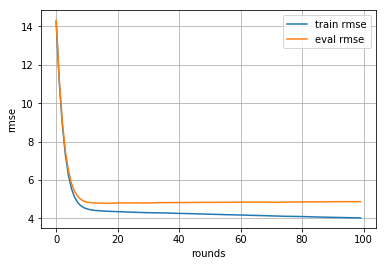

In [10]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

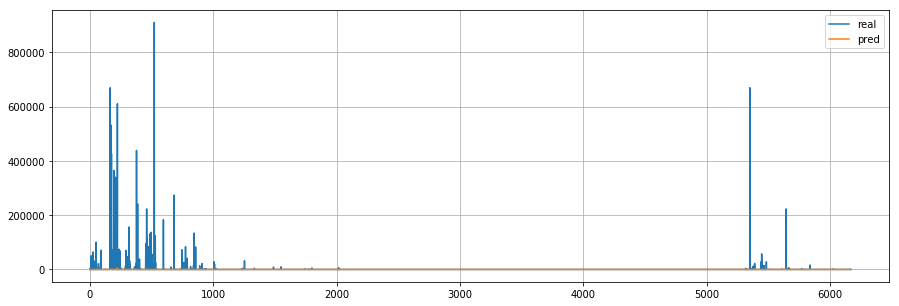

In [11]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['SalesKodateBkn'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

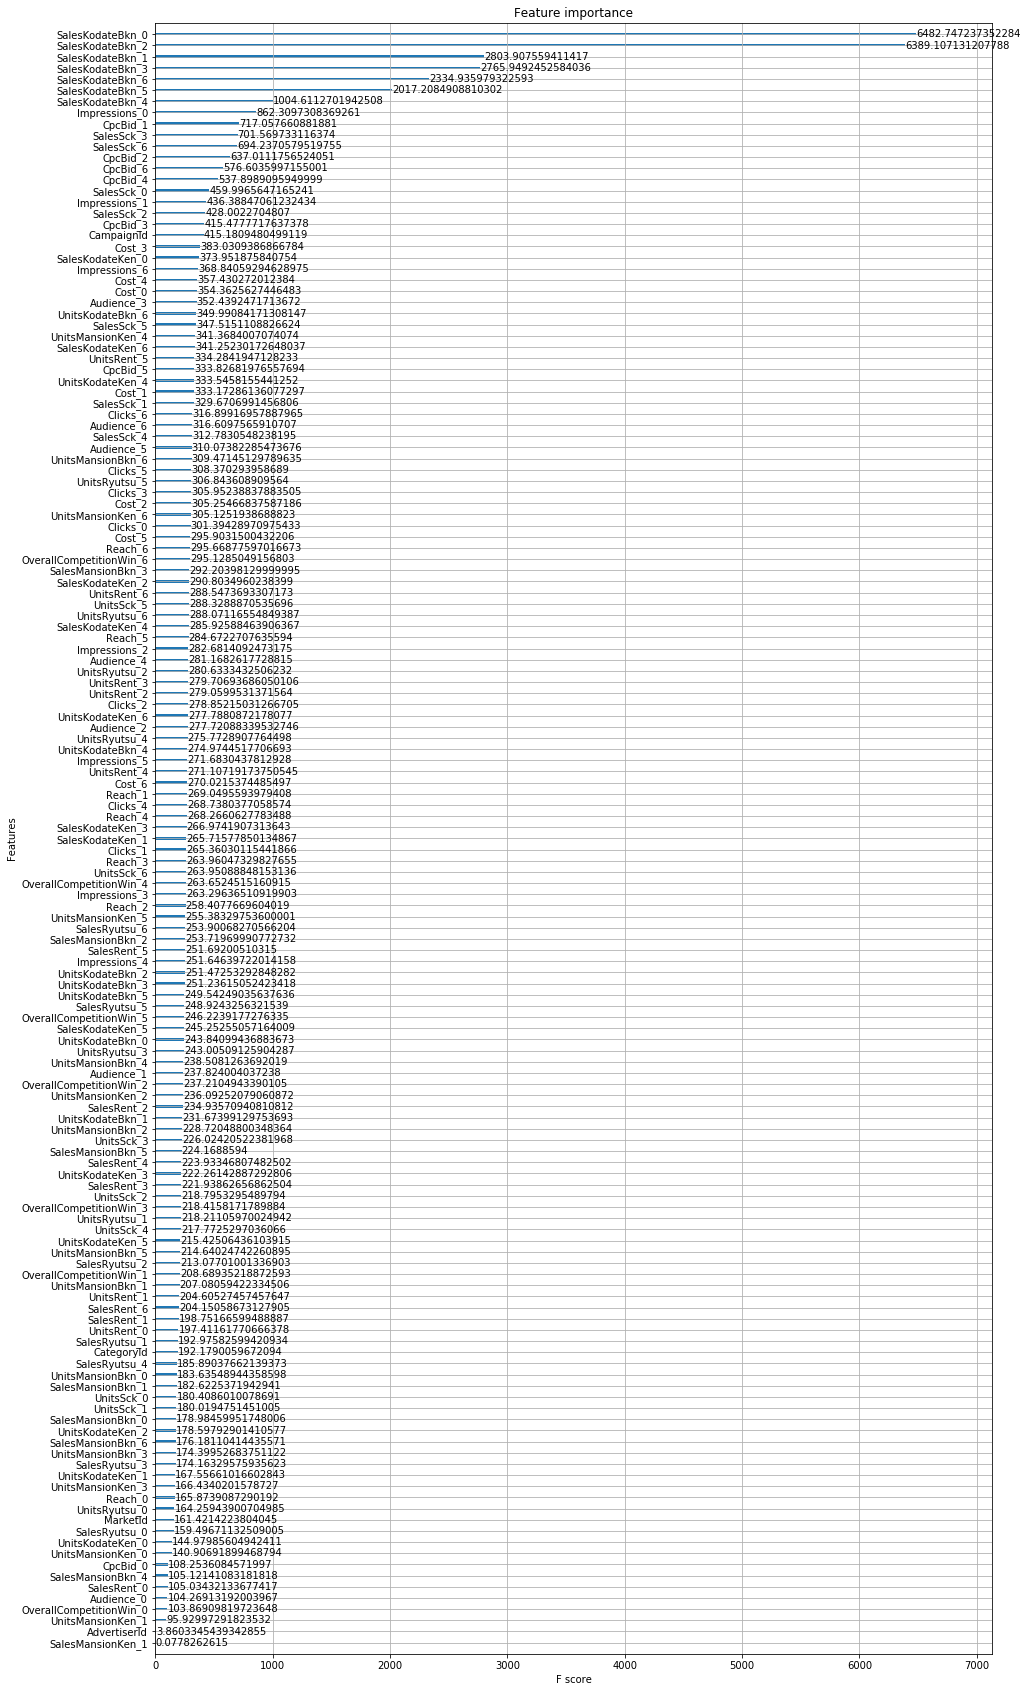

In [9]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [10]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['SalesKodateBkn_0',
 'SalesKodateBkn_2',
 'SalesKodateBkn_1',
 'SalesKodateBkn_3',
 'SalesKodateBkn_6',
 'SalesKodateBkn_5',
 'SalesKodateBkn_4',
 'Impressions_0',
 'CpcBid_1',
 'SalesSck_3',
 'SalesSck_6',
 'CpcBid_2',
 'CpcBid_6',
 'CpcBid_4',
 'SalesSck_0',
 'Impressions_1',
 'SalesSck_2',
 'CpcBid_3',
 'CampaignId',
 'Cost_3',
 'SalesKodateKen_0',
 'Impressions_6',
 'Cost_4',
 'Cost_0',
 'Audience_3',
 'UnitsKodateBkn_6',
 'SalesSck_5',
 'UnitsMansionKen_4',
 'SalesKodateKen_6',
 'UnitsRent_5',
 'CpcBid_5',
 'UnitsKodateKen_4',
 'Cost_1',
 'SalesSck_1',
 'Clicks_6',
 'Audience_6',
 'SalesSck_4',
 'Audience_5',
 'UnitsMansionBkn_6',
 'Clicks_5',
 'UnitsRyutsu_5',
 'Clicks_3',
 'Cost_2',
 'UnitsMansionKen_6',
 'Clicks_0',
 'Cost_5',
 'Reach_6',
 'OverallCompetitionWin_6',
 'SalesMansionBkn_3',
 'SalesKodateKen_2',
 'UnitsRent_6',
 'UnitsSck_5',
 'UnitsRyutsu_6',
 'SalesKodateKen_4',
 'Reach_5',
 'Impressions_2',
 'Audience_4',
 'UnitsRyutsu_2',
 'UnitsRent_3',
 'UnitsRent_2',
 'Clic